In [1]:
from __future__ import print_function
import numpy as np # Biblioteca de funciones matematicas de alto nivel
np.random.seed(1337)  # for reproducibility
import tensorflow as tf
import keras  
import pandas as pd

In [2]:
dataset = pd.read_csv('Train.csv', encoding = "ISO-8859-1") # lectura de datos
dataset1 = pd.read_csv('Test.csv', encoding = "ISO-8859-1") # lectura de datos


In [3]:
#Removed infinite and Nan values
dataset.replace([np.inf, -np.inf], -1, inplace=True) 
dataset.replace([np.nan, -np.nan], -1, inplace=True)

dataset1.replace([np.inf, -np.inf], -1, inplace=True) 
dataset1.replace([np.nan, -np.nan], -1, inplace=True)

## Remove biased variables

In [4]:
# Eliminamos los datos mal introducidos
dataset = dataset.drop(dataset[dataset['Dst Port']=='Dst Port'].index)
dataset1 = dataset1.drop(dataset1[dataset1['Dst Port']=='Dst Port'].index)

dataset = dataset[dataset['Flow IAT Min'] >= 0]
dataset1 = dataset1[dataset1['Flow IAT Min'] >= 0]
#Eliminamos las columnas innecesarias

dataset = dataset.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                       'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
dataset1 = dataset1.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                          'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
#Quitamos direcciones IP dest y src para no introducir sesgos, lo mismo con los puertos
#Quitar el puerto de destino es una modificación con respecto al trabajo original
#Eliminamos la columna de timestamp para no tener sesgo
dataset1 = dataset1.drop(['Timestamp'], axis=1)
dataset = dataset.drop(['Timestamp'], axis=1)

#Eliminamos la columna 
dataset

Protocol  Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  TotLen Fwd Pkts  \
0              6        3025021            11            15            336.0   
1              6            468             2             1             79.0   
2              6        3054906            13            15            338.0   
3              6        3046116            11            15            341.0   
4              6        3045413            13            15            351.0   
...          ...            ...           ...           ...              ...   
430151        17           9264             1             1             47.0   
430152         0       91444297            51             0              0.0   
430153        17      101164777             6             6           1332.0   
430154        17      101009912             6             6           1332.0   
430155        17           5614             1             1             49.0   

        TotLen Bwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  Fwd Pkt Len Mean  \
0                 188.0             79.0              0.0         30.545455   
1                   0.0             79.0              0.0         39.500000   
2                 188.0             79.0              0.0         26.000000   
3                 188.0             79.0              0.0         31.000000   
4                 188.0             86.0              0.0         27.000000   
...                 ...              ...              ...               ...   
430151             63.0             47.0             47.0         47.000000   
430152              0.0              0.0              0.0          0.000000   
430153           1032.0            222.0            222.0        222.000000   
430154           1032.0            222.0            222.0        222.000000   
430155             65.0             49.0             49.0         49.000000   

        Fwd Pkt Len Std  ...  Subflow Bwd Pkts  Subflow Bwd Byts  \
0             38.624768  ...                 0                 7   
1             55.861436  ...                 0                 0   
2             36.398260  ...                 0                 6   
3             38.348403  ...                 0                 7   
4             37.678464  ...                 0                 6   
...                 ...  ...               ...               ...   
430151         0.000000  ...                 0                31   
430152         0.000000  ...                 0                 0   
430153         0.000000  ...                 0                86   
430154         0.000000  ...                 0                86   
430155         0.000000  ...                 0                32   

        Init Fwd Win Byts  Init Bwd Win Byts  Fwd Act Data Pkts  Active Mean  \
0                   64240                181                  6            0   
1                     502                  0                  0            0   
2                   64240                181                  6            0   
3                   64240                181                  6            0   
4                   64240                181                  6            0   
...                   ...                ...                ...          ...   
430151                  0                  0                  0            0   
430152                  0                  0                  0            0   
430153                  0                  0                  5            0   
430154                  0                  0                  5            0   
430155                  0                  0                  0            0   

        Active Std  Active Max  Active Min           Label  
0                0           0           0  FTP-BruteForce  
1                0           0           0  FTP-BruteForce  
2                0           0           0  FTP-BruteForce  
3                0           0           0  FTP-BruteForce  
4              

In [5]:
n=0
#Convert dataset columns into float type
for column in dataset:
    column
    if column != 'Label':
        dataset[column] = dataset[column].astype(float)
        
n=0
for column in dataset1:
    column
    if column != 'Label':
        dataset1[column] = dataset1[column].astype(float)


In [6]:
Labels = dataset['Label'].unique()
Y_train = dataset["Label"]
Y_test =  dataset1["Label"]
#Fill Y values

## Removed variables without variance

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
URG Flag Cnt
CWE Flag Count
ECE Flag Cnt
Fwd Byts/b Avg
Fwd Pkts/b Avg
Fwd Blk Rate Avg
Bwd Byts/b Avg
Subflow Bwd Pkts
Active Mean
Active Std
Active Max
Active Min


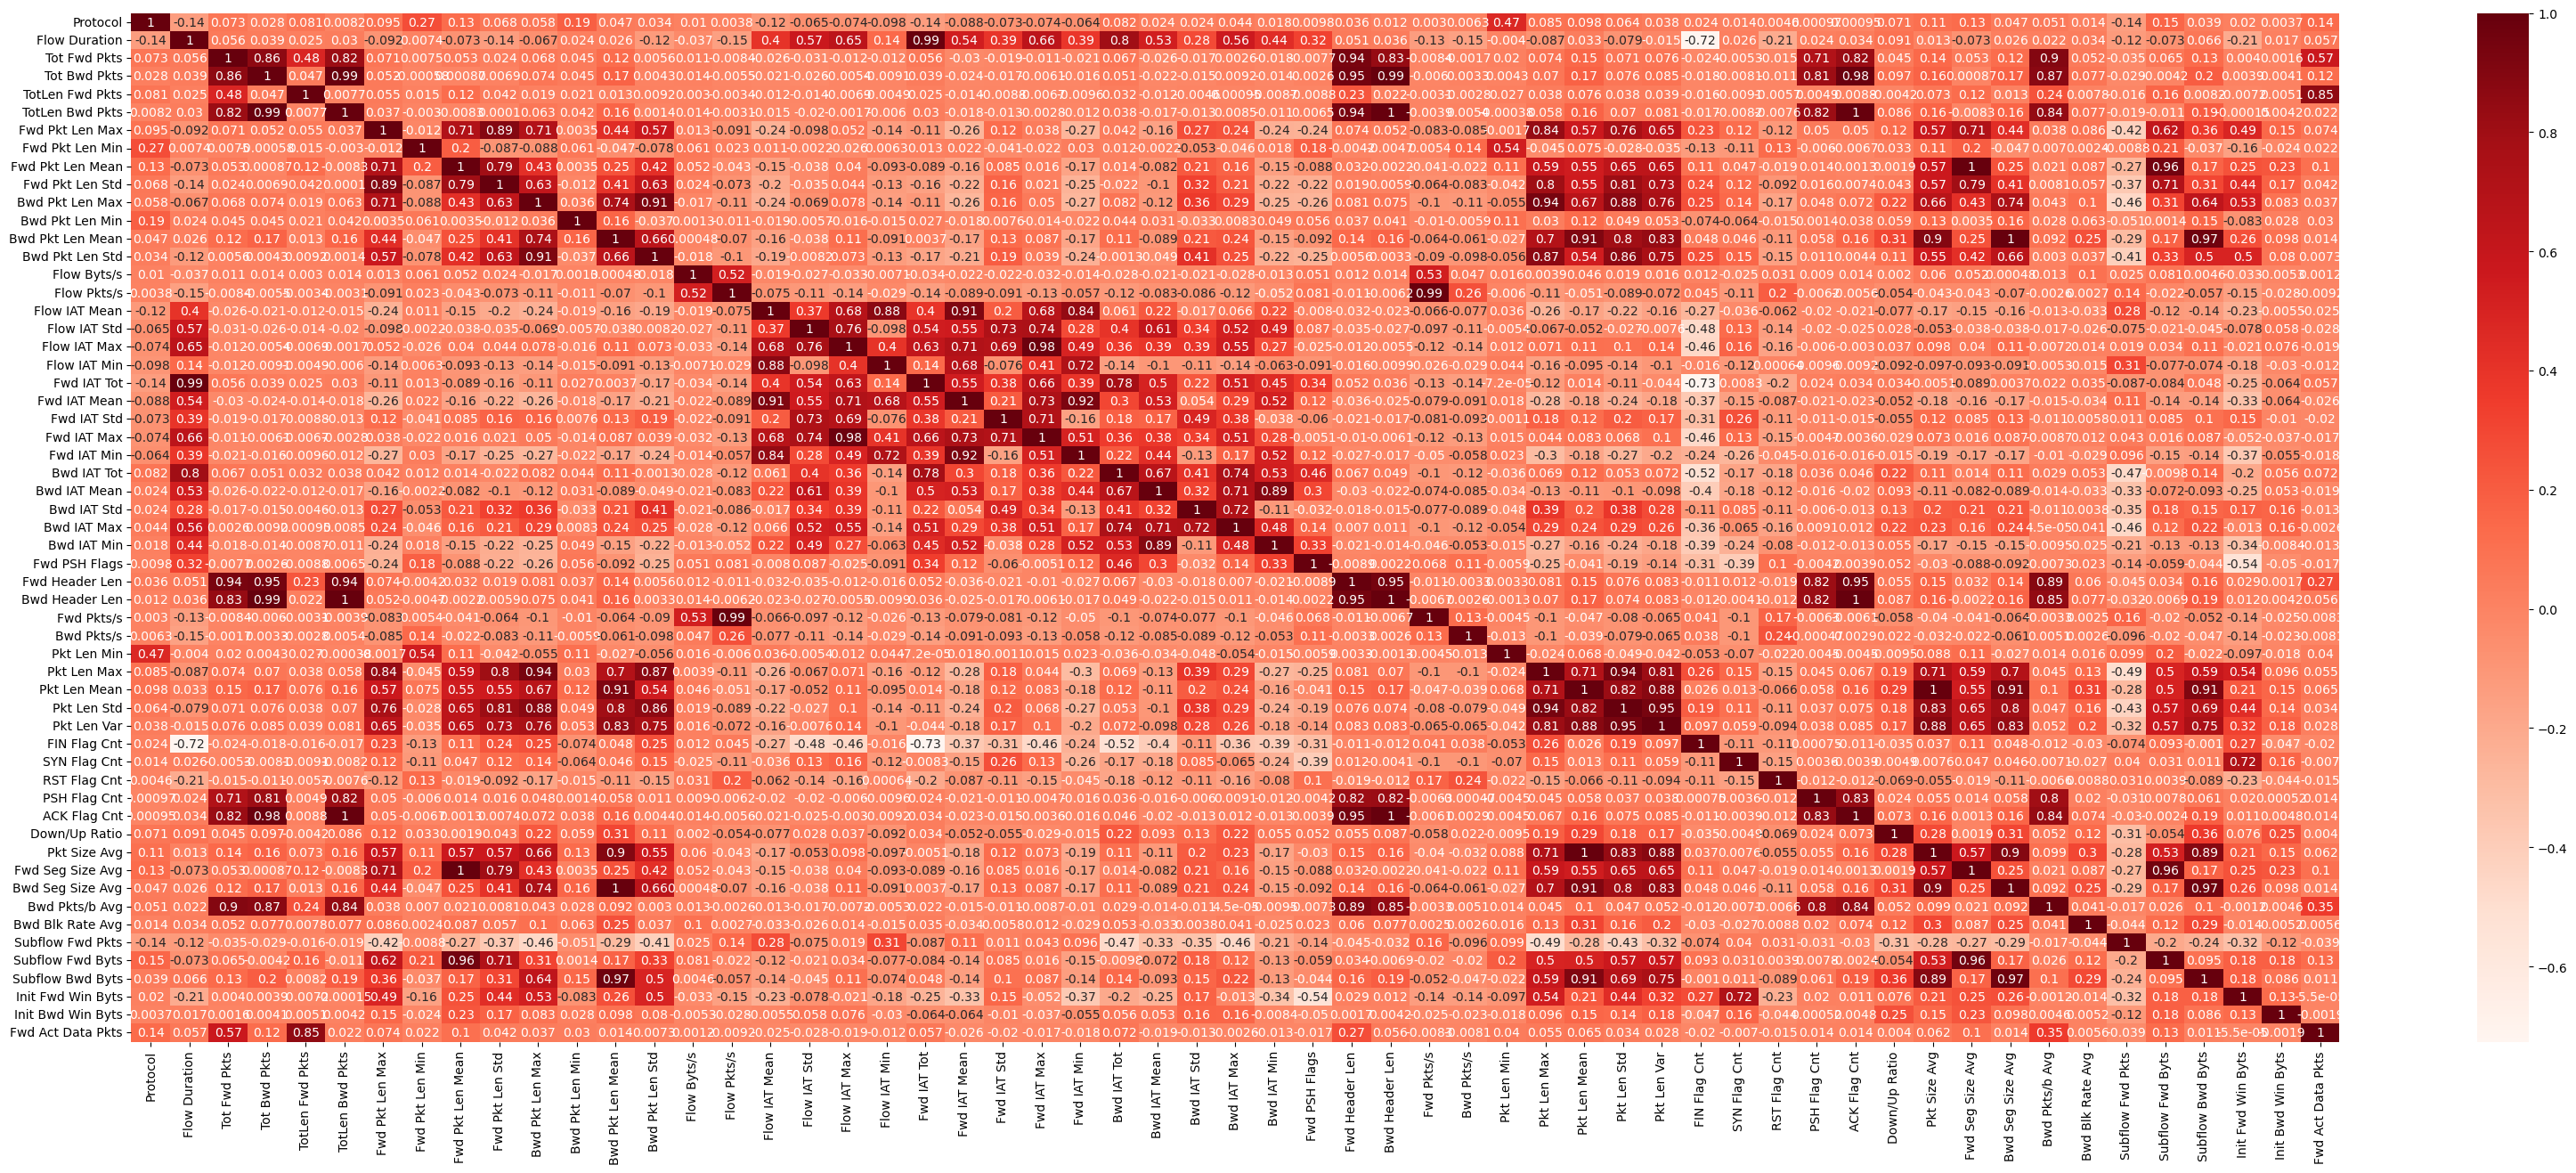

<Figure size 640x480 with 0 Axes>

In [7]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

X_train=dataset.iloc[:, 0:72] #Luego obtenemos las características del flujo
X_test=dataset1.iloc[:, 0:72]

sel = VarianceThreshold(threshold=0)
hola=sel.fit_transform(X_train)

aux=X_train.var()

#Remove variables with zero variance
for col in X_train.columns:
    if X_train[col].var() == 0:
        print(col)
        X_train=X_train.drop(col, axis =1)
        X_test=X_test.drop(col, axis =1)
       
        
#Correlation figure
plt.figure(figsize=(40, 15))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

features = list(X_train.columns)

plt.savefig('save_as_a_png.pdf')
#pintar solo con colores

In [8]:
from sklearn.preprocessing import LabelEncoder
 
lb_make = LabelEncoder()
Y_train = lb_make.fit_transform(Y_train) #para pasar a numeros
#Convert Train labels into numbers Benign->0 Goldeneye->1 ...

Labels = lb_make.inverse_transform(Y_train)
Labels = list(lb_make.classes_)
Labels

['Benign',
 'DoS attacks-GoldenEye',
 'DoS attacks-Hulk',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-Slowloris',
 'FTP-BruteForce',
 'SSH-Bruteforce']

In [9]:
Y_train
unique, counts = np.unique(Y_train, return_counts=True)
counts

array([120096,  52175,  50676,  53848,  53876,  50883,  46928],
      dtype=int64)

In [10]:
unique

array([0, 1, 2, 3, 4, 5, 6])

In [11]:
lb_make = LabelEncoder()
Y_test = lb_make.fit_transform(Y_test)
#Convert Test labels into numbers Benign->0 Goldeneye->1 ...
Labels1 = lb_make.inverse_transform(Y_test)
Labels1 = list(lb_make.classes_)
Labels1
Y_test

array([5, 5, 5, ..., 0, 0, 0])

In [12]:
dataset["Label"].value_counts()

Benign                      120096
DoS attacks-Slowloris        53876
DoS attacks-SlowHTTPTest     53848
DoS attacks-GoldenEye        52175
FTP-BruteForce               50883
DoS attacks-Hulk             50676
SSH-Bruteforce               46928
Name: Label, dtype: int64

In [13]:
unique, counts = np.unique(Y_test, return_counts=True)
counts

array([32228, 10020, 10255, 11110, 11108, 15138, 11956], dtype=int64)

## Dataset values

In [14]:
dataset1["Label"].value_counts()

Benign                      32228
FTP-BruteForce              15138
SSH-Bruteforce              11956
DoS attacks-SlowHTTPTest    11110
DoS attacks-Slowloris       11108
DoS attacks-Hulk            10255
DoS attacks-GoldenEye       10020
Name: Label, dtype: int64

## Multilayer perceptron

### Libraries

In [15]:
import shap

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

### Neural Network training

In [16]:
model = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(16,12),activation='relu', max_iter=50,random_state=0)
)

In [17]:
import time
X_trainArr=X_train.to_numpy()
#Convert X_train to numpy array due to MLP library compatibility
Y_train

inicio = time.time() #Get initial time to measure Neural Network training

model.fit(X_trainArr,Y_train)
fin = time.time()#Get final time of the MPL training
print(fin-inicio)

428.17570972442627


Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.


## Model evaluation

### Evaluation over training data

In [18]:
# evaluate the model Entrenamiento

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
X_testArr = X_test.to_numpy()
Y_pred=model.predict(X_trainArr)
LabelsArr = np.array(Labels)
Labels
LabelsArr

y_test1_text = []
for i in range(0, Y_train.size):
    for j in range(0, LabelsArr.size):
        if Y_train[i] == j:
            y_test1_text.append(Labels[j])

y_pred_text = []
for i in range(0, Y_pred.size):
    for j in range(0, LabelsArr.size):
        if Y_pred[i] == j:
            y_pred_text.append(Labels[j])
            


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test1_text, y_pred_text, digits=8, zero_division= "warn"))

                          precision    recall  f1-score   support

                  Benign  0.98451986 0.96910805 0.97675316    120096
   DoS attacks-GoldenEye  0.97038653 0.95463345 0.96244553     52175
        DoS attacks-Hulk  0.87081831 0.95337043 0.91022646     50676
DoS attacks-SlowHTTPTest  0.95796410 0.94757465 0.95274106     53848
   DoS attacks-Slowloris  0.99647384 0.99660331 0.99653857     53876
          FTP-BruteForce  0.98473706 0.97633787 0.98051948     50883
          SSH-Bruteforce  0.99882255 0.97613365 0.98734777     46928

                accuracy                      0.96786329    428482
               macro avg  0.96624604 0.96768020 0.96665315    428482
            weighted avg  0.96910955 0.96786329 0.96822065    428482



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

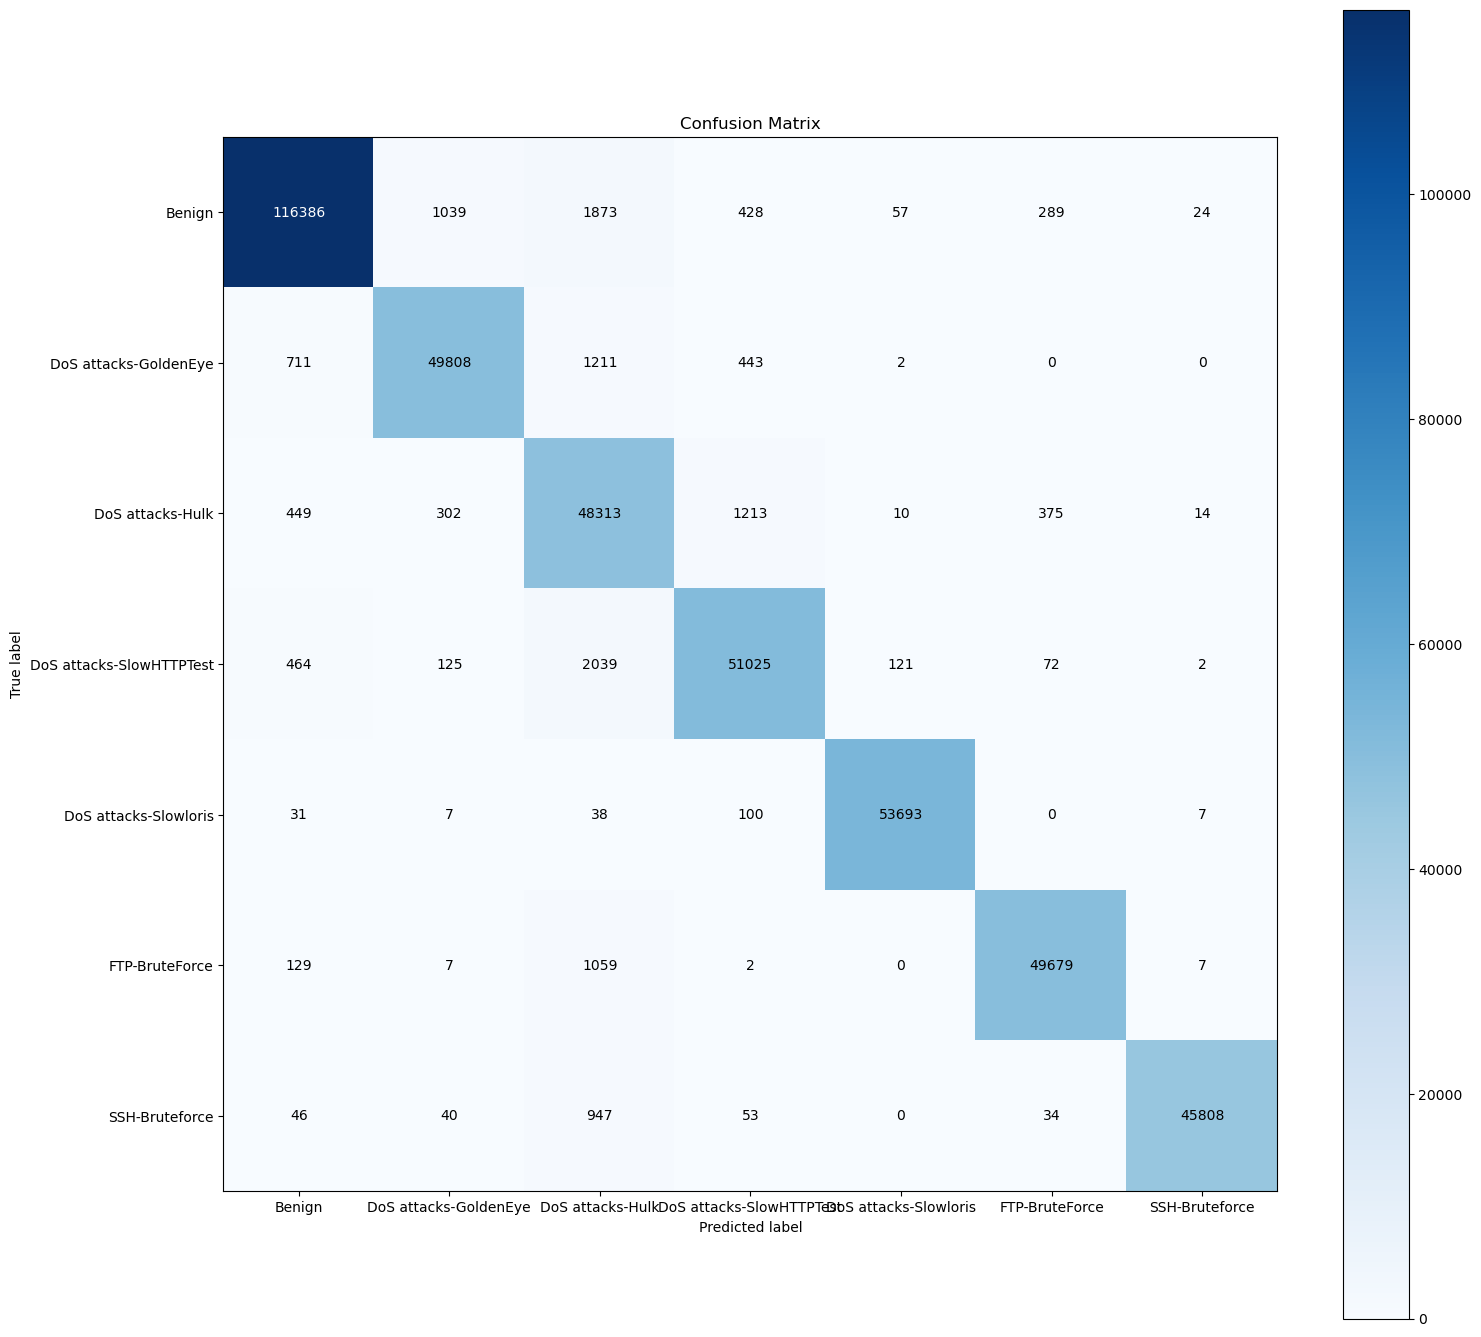

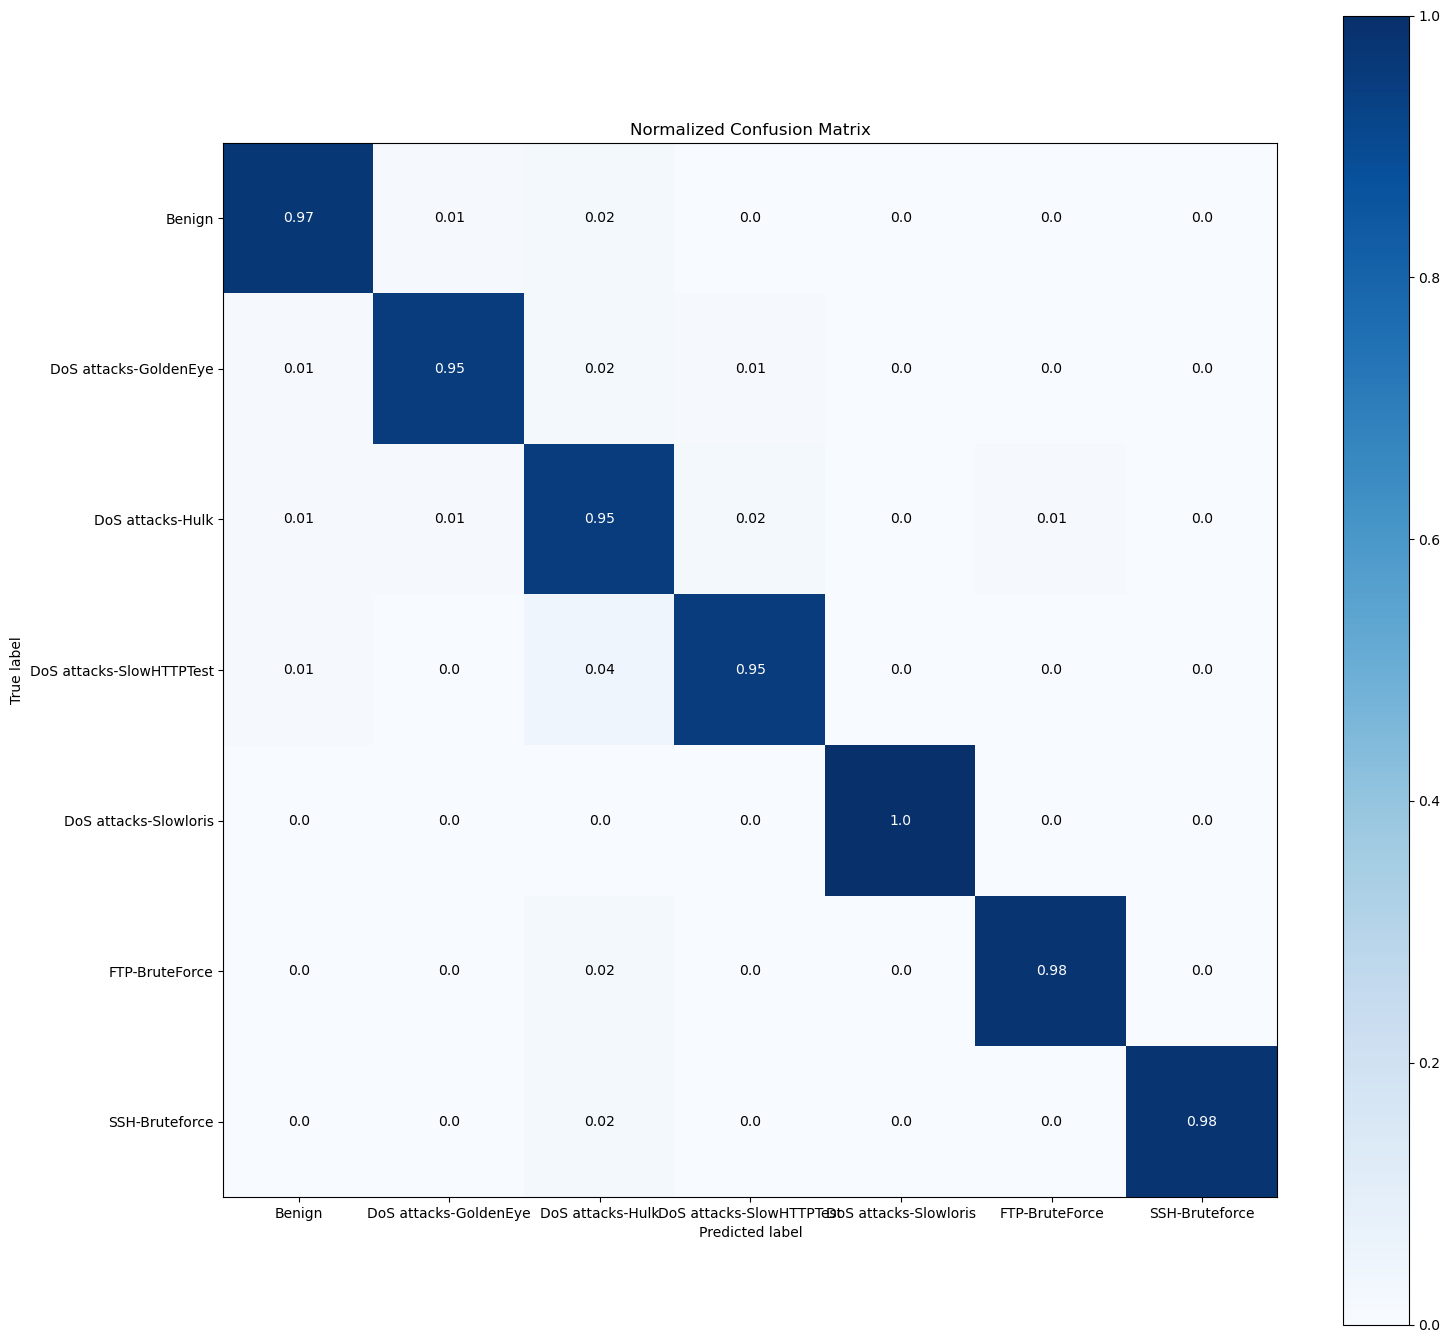

In [20]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test1_text, y_pred_text, figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_test1_text, y_pred_text, normalize= True, figsize= (17,17))

### Evaluation over test data

In [21]:
# evaluate the model
X_testArr = X_test.to_numpy()
Y_pred=model.predict(X_testArr)
LabelsArr = np.array(Labels1)
Labels
LabelsArr

y_test1_text = []
for i in range(0, Y_test.size):
    for j in range(0, LabelsArr.size):
        if Y_test[i] == j:
            y_test1_text.append(Labels[j])

y_pred_text = []
for i in range(0, Y_pred.size):
    for j in range(0, LabelsArr.size):
        if Y_pred[i] == j:
            y_pred_text.append(Labels[j])
            


In [22]:
print(classification_report(y_test1_text, y_pred_text, digits=8, zero_division= "warn"))

                          precision    recall  f1-score   support

                  Benign  0.97524466 0.94002110 0.95730898     32228
   DoS attacks-GoldenEye  0.90356540 0.90798403 0.90576933     10020
        DoS attacks-Hulk  0.89858806 0.91847879 0.90842456     10255
DoS attacks-SlowHTTPTest  0.92287188 0.96606661 0.94397537     11110
   DoS attacks-Slowloris  0.98821744 0.99666907 0.99242526     11108
          FTP-BruteForce  0.98265220 0.99907518 0.99079564     15138
          SSH-Bruteforce  0.99632599 0.99799264 0.99715862     11956

                accuracy                      0.95930855    101815
               macro avg  0.95249509 0.96089820 0.95655111    101815
            weighted avg  0.95974679 0.95930855 0.95934759    101815



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

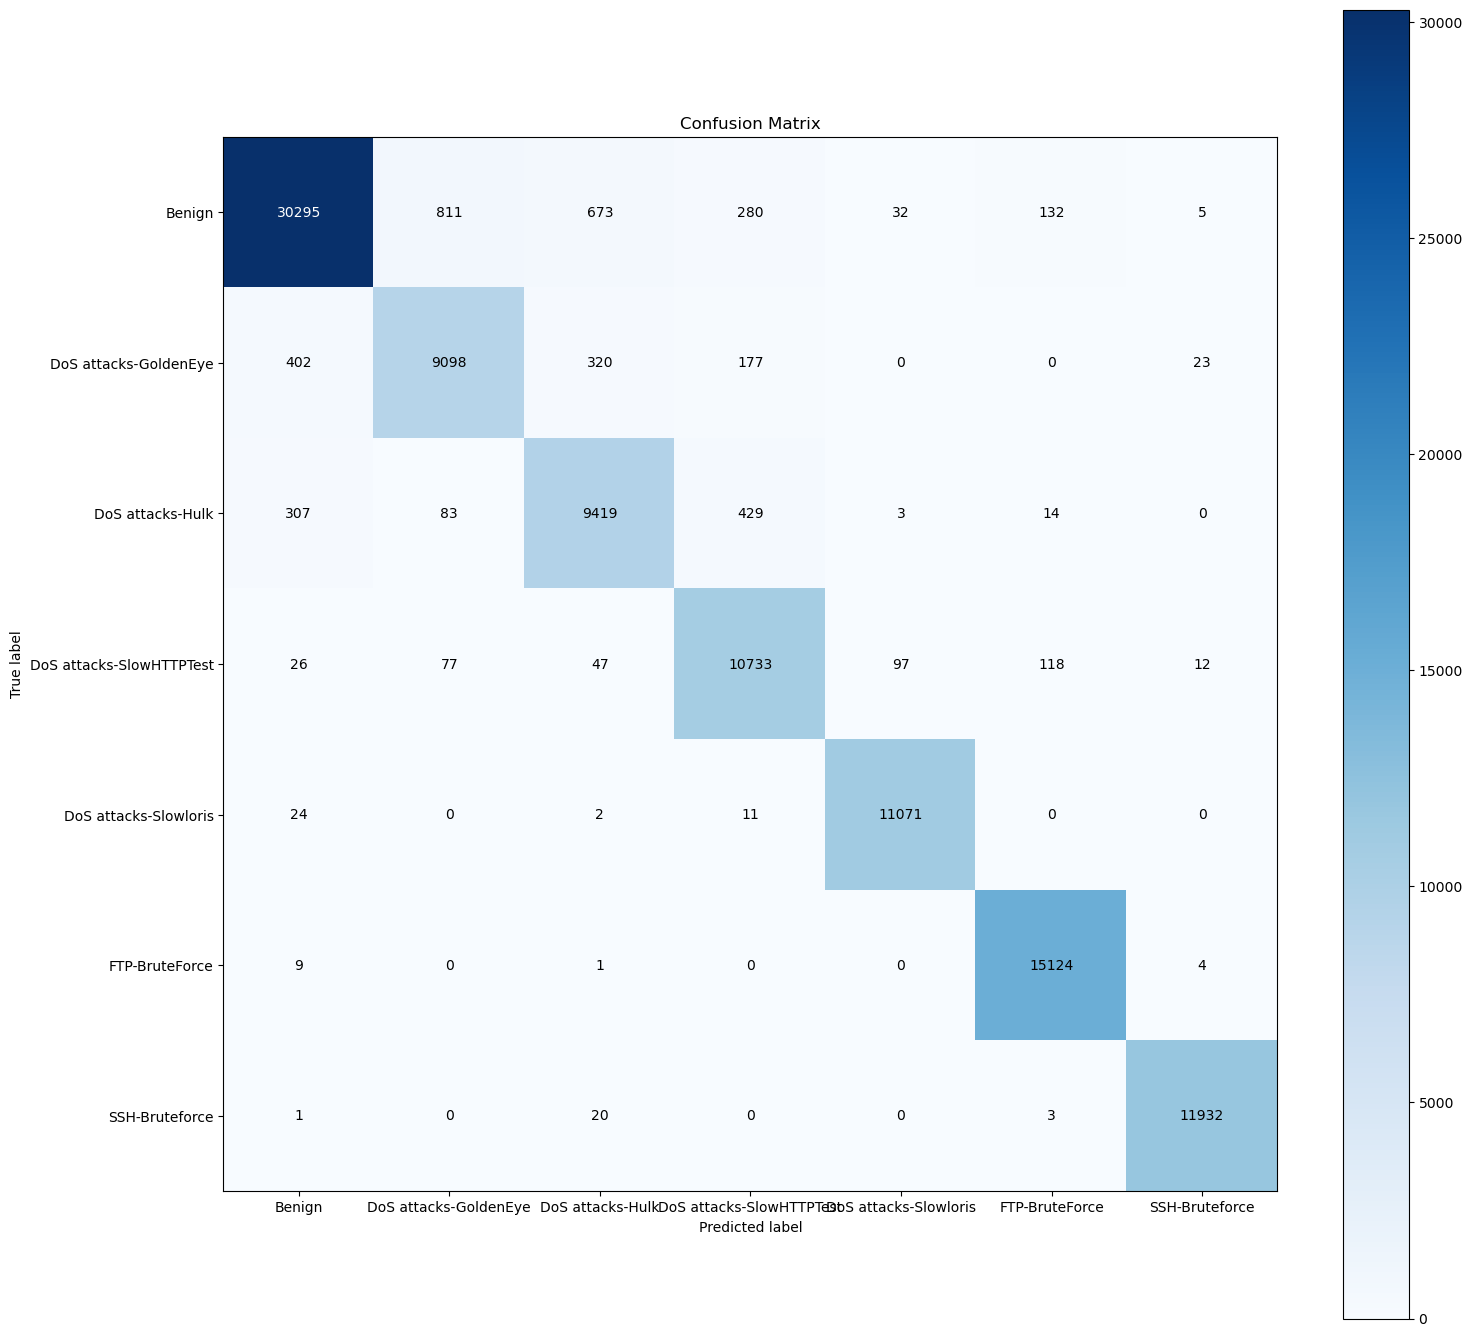

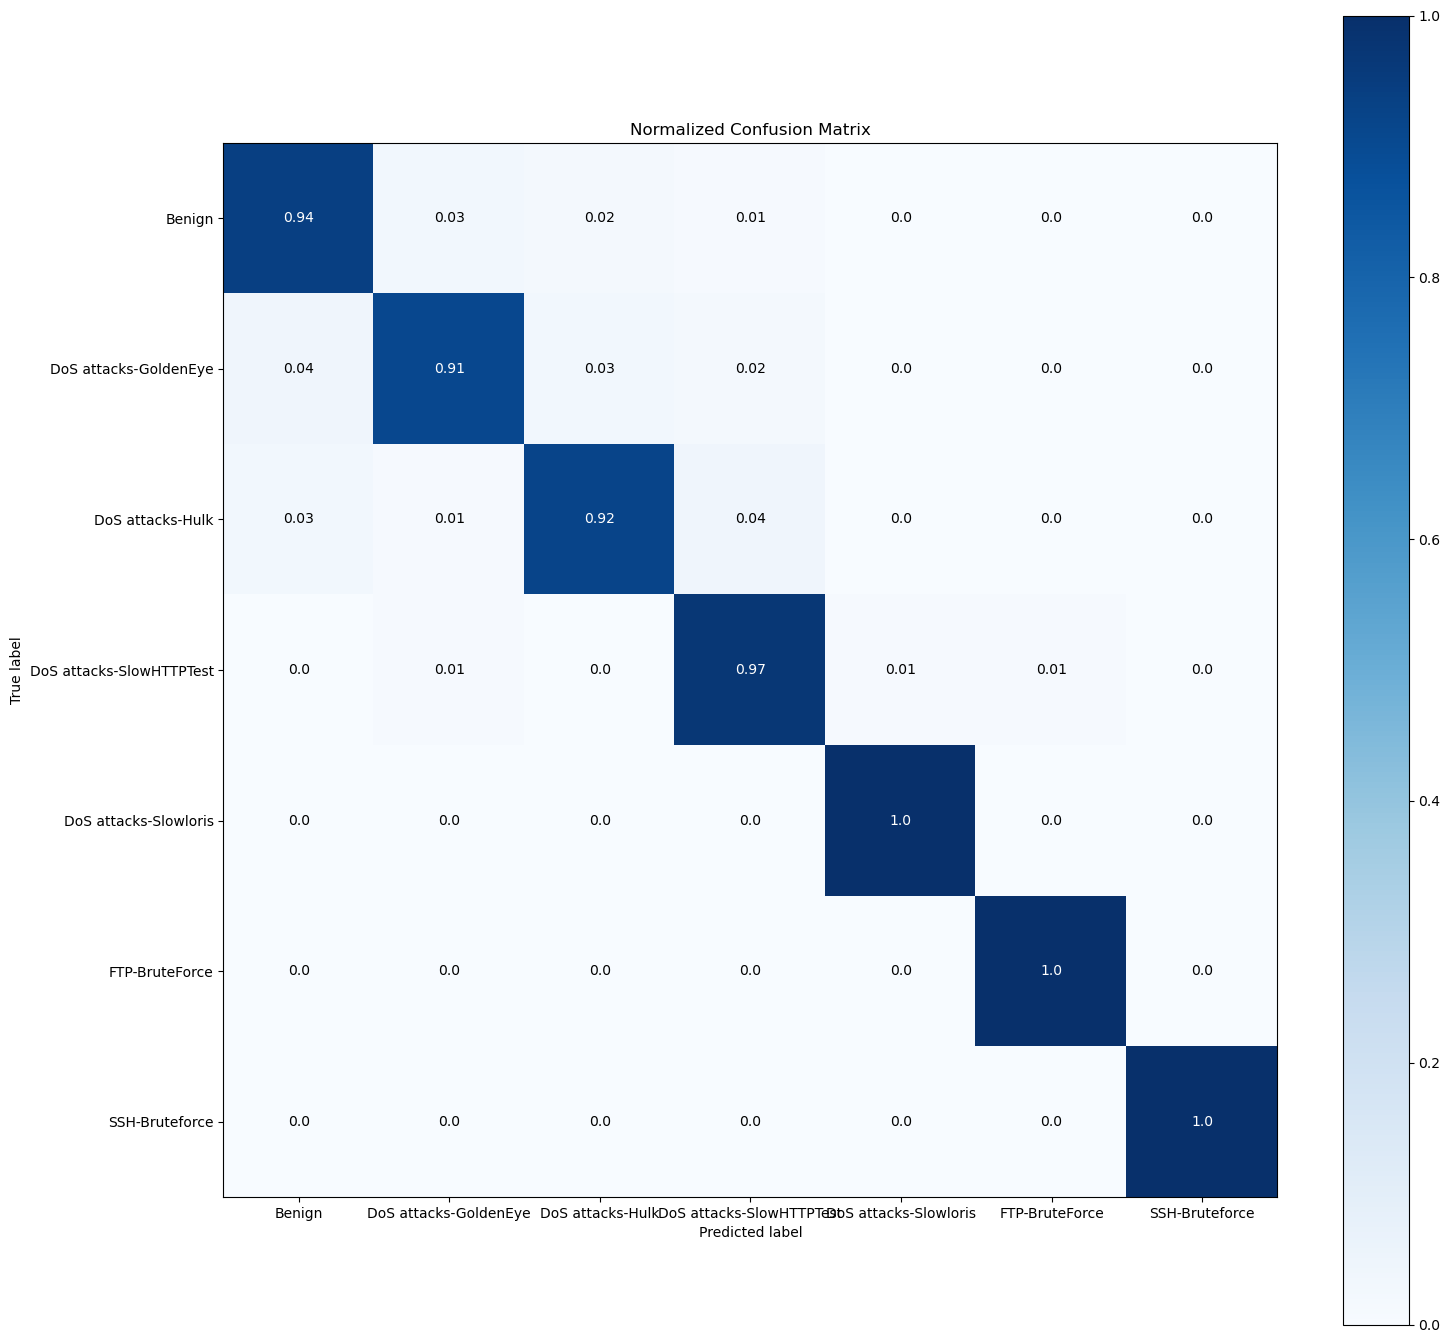

In [23]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test1_text, y_pred_text, figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_test1_text, y_pred_text, normalize= True, figsize= (17,17))



## XAI technique: SHAP

In [24]:
size=200 #Data sample to examinate. More data implies much more time to process
data=shap.sample(X_trainArr, size)
explainer = shap.KernelExplainer(model.predict,data)
expected_value = explainer.expected_value
data1=shap.sample(X_testArr, size)
shap_values = explainer.shap_values(data1,nsamples=size)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

### SHAP Graphic 1

In [25]:
#np.savetxt('testV3.1.txt',shap_values)


#shap_values = np.loadtxt('testV3.1.txt')
#print(shap_values.shape)

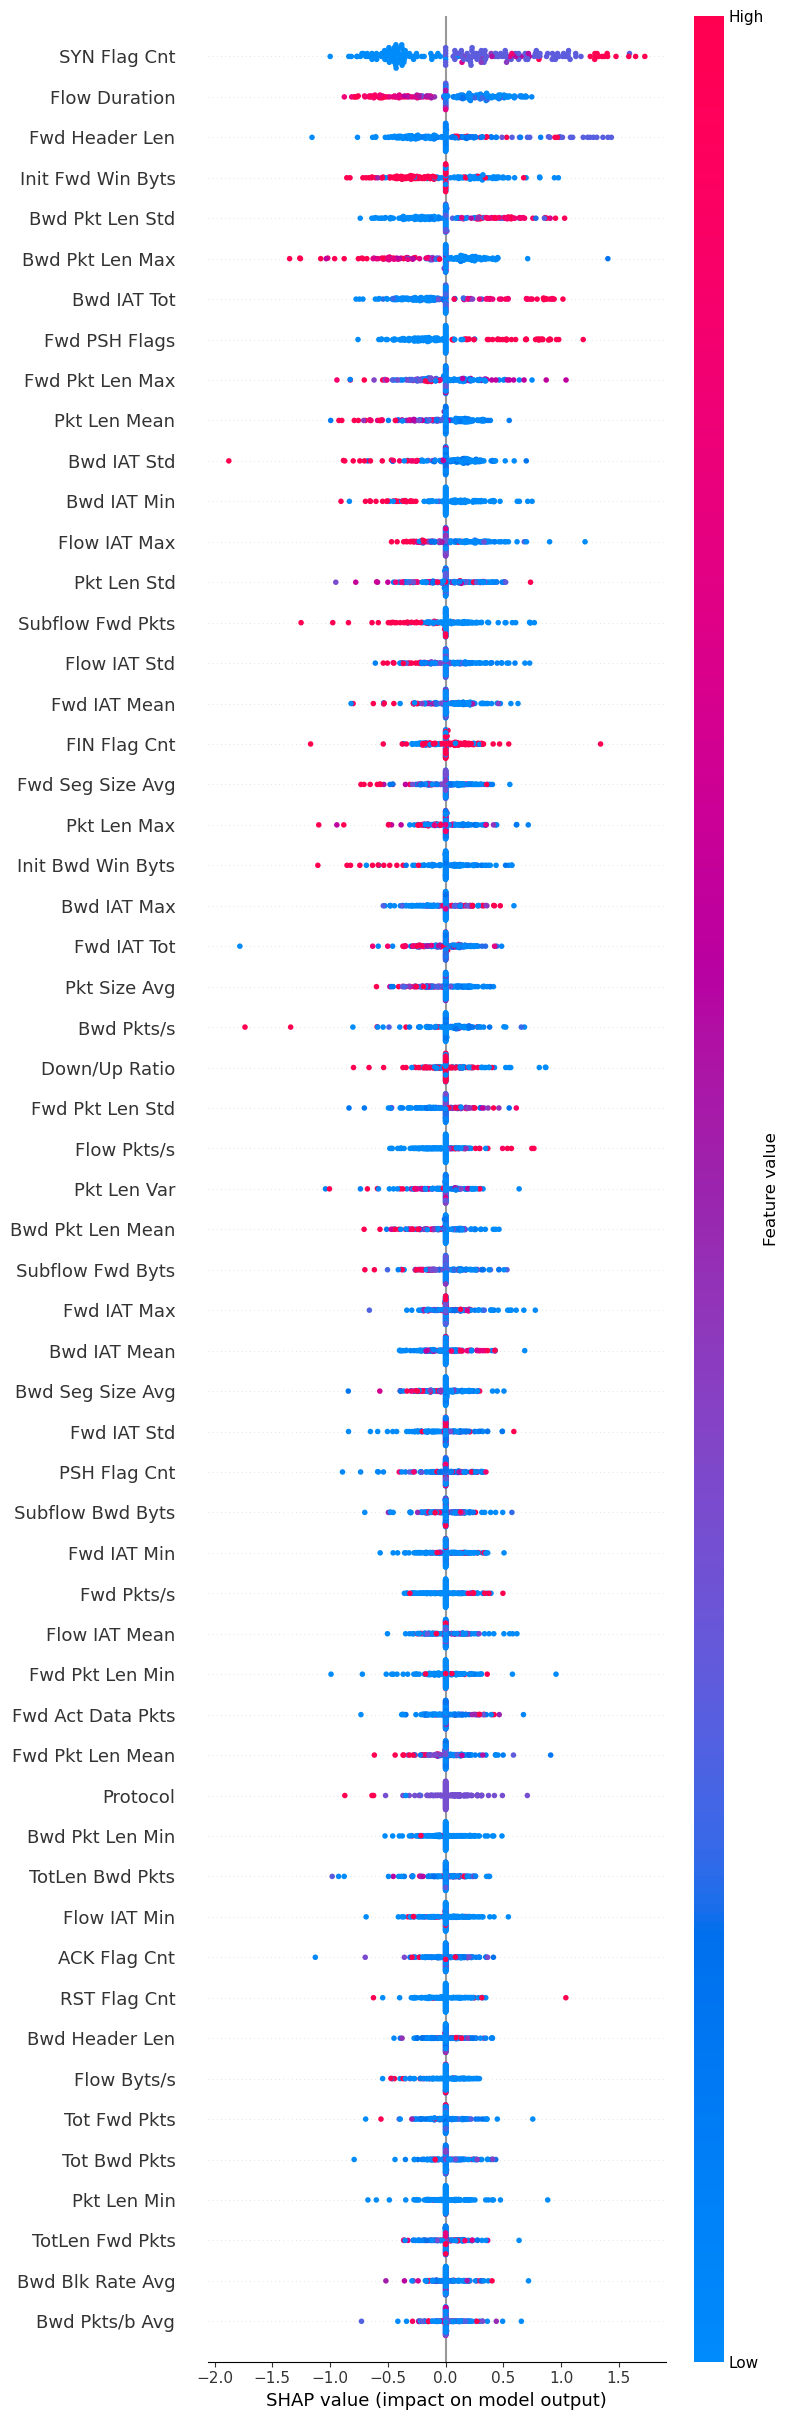

In [26]:
shap.summary_plot(shap_values,data1,feature_names=features, max_display=57)

### SHAP graphic 2
Main features and their contribution

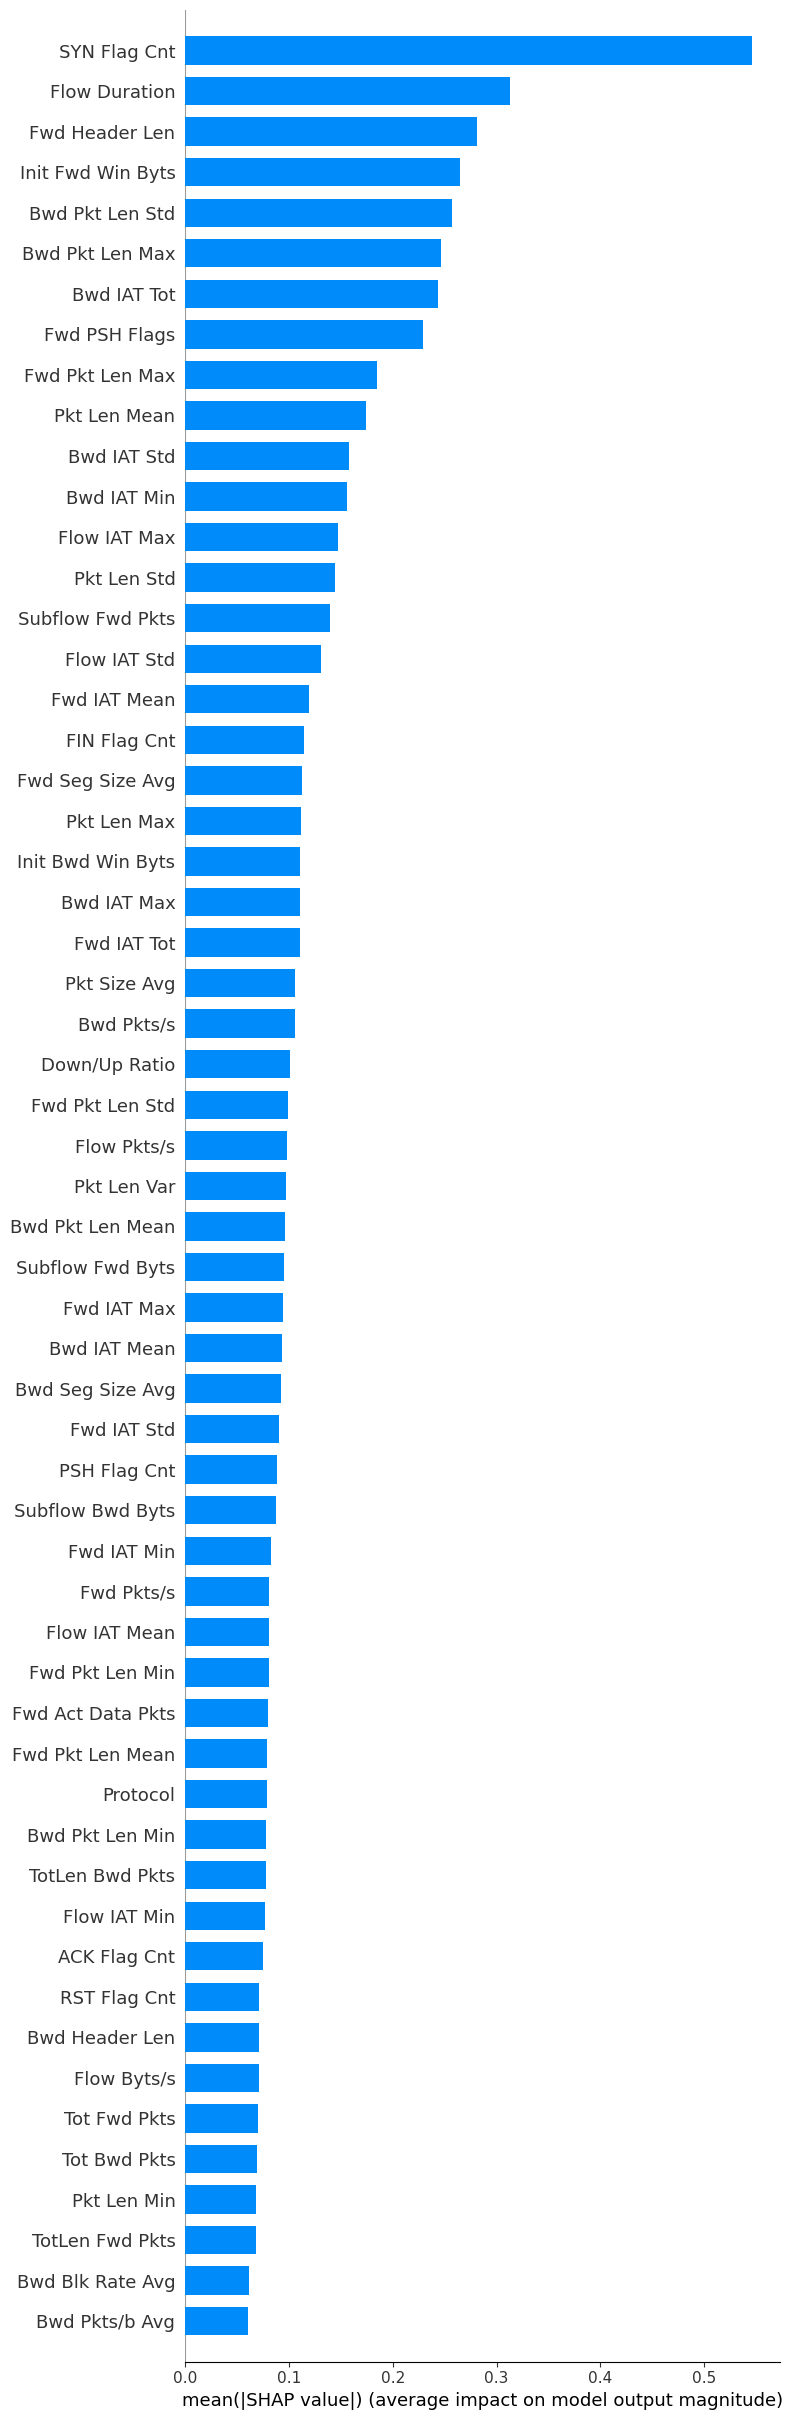

In [27]:
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names = features, max_display=65)

count    428482.000000
mean          0.210144
std           0.407411
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Fwd PSH Flags, dtype: float64


(0.0, 2.0)

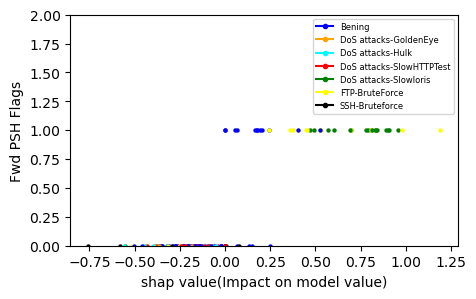

In [28]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#Fwd Seg Size Min,Bwd Pkt Len Std, Fwd Pkt Len Std,Fwd PSH flags,SYN Flag Cnt, Pkt Len Var
#caracteristica='Fwd Header Len'
caracteristica="Fwd PSH Flags"
pos=np.char.find(features,caracteristica, start=0, end=None)
pos =np.where(pos == 0)
pos = int(pos[0])
plt.rcParams["figure.figsize"] = (5,3)
y_preddata=model.predict(data1)

col =[]
x=shap_values[:,pos]
y= data1[:,pos]
for i in range(0, len(data1[:,pos])):
    if y_preddata[i]==0:
        col.append('blue')  
    elif y_preddata[i]==1:
        col.append('orange') 
    elif y_preddata[i]==2:
        col.append('cyan') 
    elif y_preddata[i]==3:
        col.append('red') 
    elif y_preddata[i]==4:
        col.append('green') 
    elif y_preddata[i]==5:
        col.append('yellow') 
    elif y_preddata[i]==6:
        col.append('black')
  

for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 10,linewidth = 0)

plt.ylabel(caracteristica) 
plt.xlabel('shap value(Impact on model value)') 
custom_lines = [Line2D([0], [0], marker='o', color='b',      label='Bening', markersize=3),
                Line2D([0], [0], marker='o', color='orange', label='DoS attacks-GoldenEye', markersize=3),
                Line2D([0], [0], marker='o', color='cyan',   label='DoS attacks-Hulk', markersize=3),
                Line2D([0], [0], marker='o', color='red',    label='DoS attacks-SlowHTTPTest', markersize=3),
                Line2D([0], [0], marker='o', color='green',  label='DoS attacks-Slowloris', markersize=3),
                Line2D([0], [0], marker='o', color='yellow', label='FTP-BruteForce', markersize=3),
                Line2D([0], [0], marker='o', color='black',  label='SSH-Bruteforce', markersize=3),
               ]


plt.legend(handles= custom_lines,loc="best", prop={'size': 6})
print(dataset[caracteristica].describe())
plt.ylim([0, 2])

### Results verification
With the following code it is possible to representate a dataset feature histogram. You only have to change "caracteris", bin and lim

Benign
minimo:  0.0
media:  56817866.55214162
maximo:  119999999.0


Text(0.5, 0, 'Tiempo (segundos)')

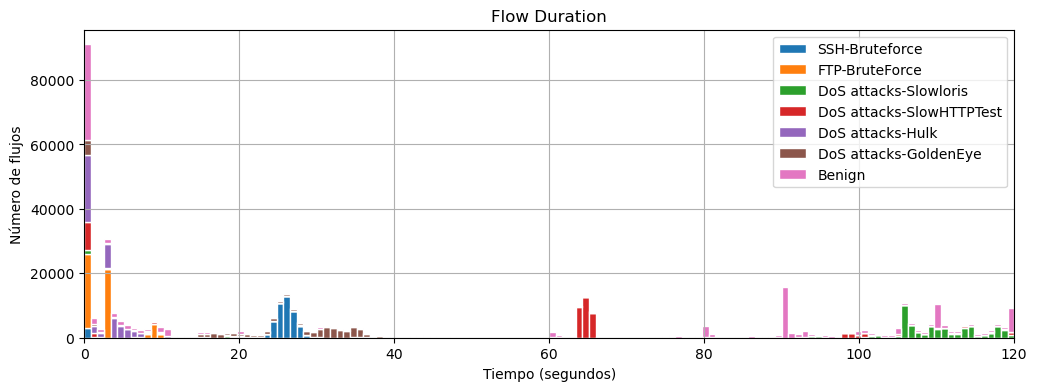

In [29]:
#0-Bening
#1-DoS attacks-GoldenEye
#2-DoS attacks-Hulk
#3-'DoS attacks-SlowHTTPTest
#4-'DoS attacks-Slowloris
#5'FTP-BruteForce,
#6'SSH-Bruteforce'
import matplotlib.pyplot as plt
caracteris= 'Flow Duration'
#fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True,figsize=(12,4))
lim=65550


pruebadf=dataset.loc[dataset[caracteris] > -1]


#brutedf=pruebadf.loc[pruebadf['Label'] == "SSH-Bruteforce"]
#Benigndf=pruebadf.loc[pruebadf['Label'] == "Benign"]

bin = 140


#pruebadf.hist(column=caracteris, ax = ax[0][0],bins = bin)
#brutedf.hist(column=caracteris, ax = ax[0][1],color="red",bins = bin)
#Benigndf.hist(column=caracteris, ax = ax[2],color="green",bins = bin)

#fig , ax =plt.subplots(nrows=1, ncols=1,figsize=(12,4))

#ax[0].hist(pruebadf['Fwd Header Len'],
#          edgecolor='white',
#        bins=bin)

#ax[2].set_title(caracteris+ " en tráfico benigno")
#print(dataset[caracteris].describe())
plt.rcParams["figure.figsize"] = (12,4)

n, bins, patches = plt.hist(
    [pruebadf.loc[pruebadf['Label'] == 'SSH-Bruteforce',caracteris]/1e6,
     pruebadf.loc[pruebadf['Label'] == 'FTP-BruteForce',caracteris]/1e6,
     pruebadf.loc[pruebadf['Label'] == 'DoS attacks-Slowloris',caracteris]/1e6,
     pruebadf.loc[pruebadf['Label'] == 'DoS attacks-SlowHTTPTest',caracteris]/1e6,
     pruebadf.loc[pruebadf['Label'] == 'DoS attacks-Hulk',caracteris]/1e6,
     pruebadf.loc[pruebadf['Label'] == 'DoS attacks-GoldenEye',caracteris]/1e6,
     pruebadf.loc[pruebadf['Label'] == 'Benign',caracteris]/1e6],
    stacked=True,
    label=['SSH-Bruteforce', 'FTP-BruteForce', 'DoS attacks-Slowloris','DoS attacks-SlowHTTPTest','DoS attacks-Hulk'
           ,'DoS attacks-GoldenEye','Benign'],
    edgecolor='white',
    bins = bin,
    )

#0-Bening
#1-DoS attacks-GoldenEye
#2-DoS attacks-Hulk
#3-'DoS attacks-SlowHTTPTest
#4-'DoS attacks-Slowloris
#5'FTP-BruteForce,
#6'SSH-Bruteforce
ata="Benign"
features = caracteris

print(ata)
print("minimo: ",dataset.loc[dataset['Label'] == ata,features].min())
print("media: ",dataset.loc[dataset['Label'] == ata,features].mean())
print("maximo: ",dataset.loc[dataset['Label'] == ata,features].max())



plt.legend()
plt.grid()
plt.title(caracteris)
plt.xlim([0, 120])
plt.ylabel("Número de flujos")
plt.xlabel("Tiempo (segundos)")

#fig.savefig("Fwd_header_len.pdf")

### Results verification
With the following code it is possible to representate a dataset feature histogram. You only have to change "caracteris", bin and lim

count    428482.000000
mean          1.556282
std           2.041932
min           0.000000
25%           0.000000
50%           2.000000
75%           2.000000
max          12.000000
Name: SYN Flag Cnt, dtype: float64


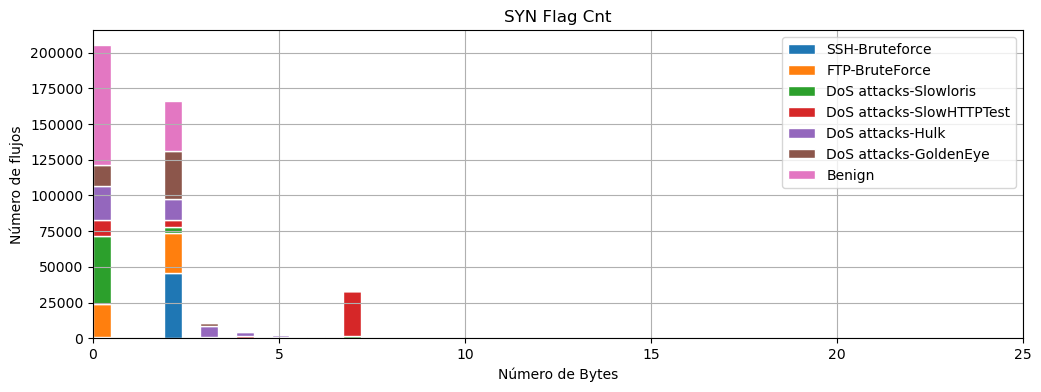

In [30]:
caracteris= 'SYN Flag Cnt'

lim=25
pruebadf=dataset.loc[dataset[caracteris] < lim]
print(dataset[caracteris].describe())
bin = 25

plt.rcParams["figure.figsize"] = (12,4)

n, bins, patches = plt.hist(
    [pruebadf.loc[pruebadf['Label'] == 'SSH-Bruteforce',caracteris],
     pruebadf.loc[pruebadf['Label'] == 'FTP-BruteForce',caracteris],
     pruebadf.loc[pruebadf['Label'] == 'DoS attacks-Slowloris',caracteris],
     pruebadf.loc[pruebadf['Label'] == 'DoS attacks-SlowHTTPTest',caracteris],
     pruebadf.loc[pruebadf['Label'] == 'DoS attacks-Hulk',caracteris],
     pruebadf.loc[pruebadf['Label'] == 'DoS attacks-GoldenEye',caracteris],
     pruebadf.loc[pruebadf['Label'] == 'Benign',caracteris]],
    stacked=True,
    label=['SSH-Bruteforce', 'FTP-BruteForce', 'DoS attacks-Slowloris','DoS attacks-SlowHTTPTest','DoS attacks-Hulk'
           ,'DoS attacks-GoldenEye','Benign'],
    edgecolor='white',
    bins = bin,
    )

#x=pruebadf.loc[pruebadf['Label'] == 'DoS attacks-GoldenEye',caracteris]
#print(x.describe())
plt.legend()
plt.grid()
plt.title(caracteris)
plt.xlim([0, lim])
plt.ylabel("Número de flujos")
plt.xlabel("Número de Bytes")
plt.savefig("Flow Duration2.pdf")

(0.0, 1000.0)

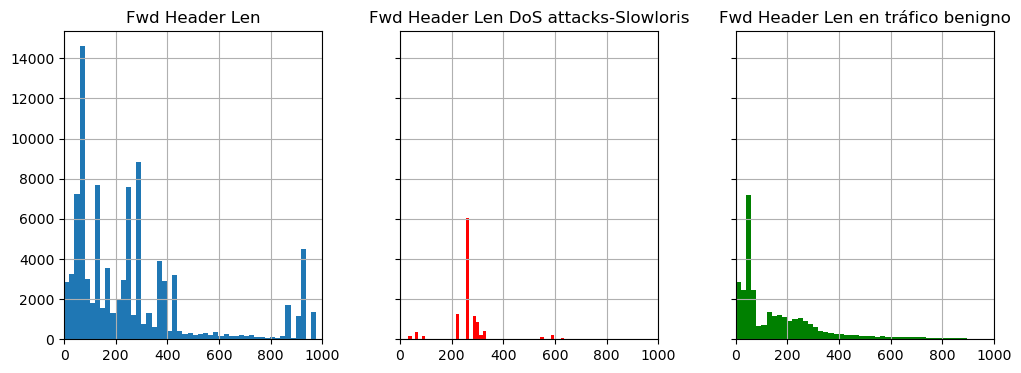

In [31]:
#Histograma del FWdSigSezSize

caracteris= 'Fwd Header Len'
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True,figsize=(12,4))
lim=1000

pruebadf=dataset1.loc[dataset1[caracteris] < lim]
evildf=pruebadf.loc[pruebadf['Label'] == 'DoS attacks-Slowloris']
Benigndf=pruebadf.loc[pruebadf['Label'] == "Benign"]

bin = 50


pruebadf.hist(column=caracteris, ax = ax[0],bins = bin)
evildf.hist(column=caracteris, ax = ax[1],color="red",bins = bin)
Benigndf.hist(column=caracteris, ax = ax[2],color="green",bins = bin)


ax[0].set_title(caracteris )
ax[1].set_title( caracteris+" DoS attacks-Slowloris")
ax[2].set_title(caracteris+ " en tráfico benigno")

ax[0].set_xlim([0, lim])

ax[1].set_xlim([0, lim])

ax[2].set_xlim([0, lim])


### SHAP Graphic 3
Features contribution to neural network output

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,data1,feature_names=features, out_names=Labels)
#0-Bening
#1-DoS attacks-GoldenEye
#2-DoS attacks-Hulk
#3-'DoS attacks-SlowHTTPTest
#4-'DoS attacks-Slowloris
#5'FTP-BruteForce,
#6'SSH-Bruteforce' FWD header Len 936, BWD packt Len STD 176, Fwd Pack Len std 166


In [33]:
y_preddata=model.predict(data1)


### SHAP graphic 3
Contribution of a single flow

In [34]:
num=25;

shap.force_plot(explainer.expected_value, shap_values[num,:]  ,data1[num,:],feature_names=features, figsize=[15,28])
#1 maligno #0 benigno

In [35]:
#feature = [a + ": " + str(int(b)) for a,b in zip(features, data1[num].round(0))]

#shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[num],feature_names=feature, max_display=80)


### SHAP graphic 5
In this case the graphic shows the mean SHAP values of every flow that the Neural network identifies as a SSH-bruteforce attack. You can switch the attack kind by typing another number in the variable "ata".

#0-Bening
#1-DoS attacks-GoldenEye
#2-DoS attacks-Hulk
#3-'DoS attacks-SlowHTTPTest
#4-'DoS attacks-Slowloris
#5'FTP-BruteForce,
#6'SSH-Bruteforce
nuevo_shap=shap_values[0]*0
nuevo_data = data1[0]*0
nuevo_min=data1[0]
nuevo_max=nuevo_data
nuevo_std=nuevo_data

acum=0
ata=1

print(Labels[ata])
margen=0.2
for i in range(size):
    suma=shap_values[i].sum()+explainer.expected_value
    if  (suma > (ata-abs(margen)))  and (suma < (ata+abs(margen))):
        nuevo_shap=nuevo_shap+shap_values[i]
        nuevo_data=nuevo_data+data1[i]
        nuevo_min =np.minimum(nuevo_min,data1[i])
        nuevo_max =np.maximum(nuevo_max,data1[i])
        acum=acum+1
nuevo_shap=nuevo_shap/acum
nuevo_data=nuevo_data/acum
#Calculo del STD
for i in range(size):
    suma=shap_values[i].sum()+explainer.expected_value
    if  (suma > (ata-abs(margen)))  and (suma < (ata+abs(margen))):
        
        nuevo_std= nuevo_std+((data1[i]-nuevo_data)**2)
       
nuevo_std = (nuevo_std/acum)**0.5

#print('{0:,}'.format(int(nuevo_max[1])))
#"|" + '{0:,}'.format(int(e)) 
feature = [a + "\n" + '{0:,}'.format(b) +"|" +'{0:,}'.format(c) +"|" +'{0:,}'.format(d)
           for a,b,c,d in zip(features,dataset.loc[dataset['Label'] == Labels[ata],features].min().round(1),
                                dataset.loc[dataset['Label'] == Labels[ata],features].mean().round(1),
                                dataset.loc[dataset['Label'] == Labels[ata],features].max().round(1),
                               )]
print(Labels[ata])
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, nuevo_shap,feature_names=feature, max_display=60)

#shap.summary_plot(shap_values, data1, plot_type="bar", class_names= Labels1, feature_names = features)
#Revisar que significa el explainer expecteed value

# Random Forest

In [41]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import tree


### Random Forest train

In [44]:
#clf = tree.DecisionTreeClassifier(random_state=0)
n_estimators=200
clf = RandomForestClassifier(random_state=0,n_estimators=n_estimators,max_depth=17)
#    max_features
inicio = time.time()
clf = clf.fit(X_trainArr,Y_train)
fin = time.time()
tiempo_random = fin-inicio
print(tiempo_random)

265.13811349868774


### Random Forest train evaluation

In [45]:
X_testArr = X_test.to_numpy()
Y_pred=clf.predict(X_trainArr)
LabelsArr = np.array(Labels)

y_testree1 = []
for i in range(0, Y_train.size):
    for j in range(0, LabelsArr.size):
        if Y_train[i] == j:
            y_testree1.append(Labels[j])

y_predtree1 = []
for i in range(0, Y_pred.size):
    for j in range(0, LabelsArr.size):
        if Y_pred[i] == j:
            y_predtree1.append(Labels[j])

In [46]:
print(classification_report(y_testree1, y_predtree1, digits=8, zero_division= "warn"))
accuracy_modelo=accuracy_score(Y_train, Y_pred)
print(accuracy_modelo)
# 0.91882740 max 5

                          precision    recall  f1-score   support

                  Benign  1.00000000 0.99994171 0.99997086    120096
   DoS attacks-GoldenEye  0.99691088 0.98345951 0.99013951     52175
        DoS attacks-Hulk  0.92542557 0.97730681 0.95065887     50676
DoS attacks-SlowHTTPTest  0.99112950 0.95656292 0.97353947     53848
   DoS attacks-Slowloris  0.99838695 0.99948029 0.99893332     53876
          FTP-BruteForce  0.98506071 0.99652143 0.99075793     50883
          SSH-Bruteforce  1.00000000 0.98075776 0.99028541     46928

                accuracy                      0.98724100    428482
               macro avg  0.98527337 0.98486149 0.98489791    428482
            weighted avg  0.98771237 0.98724100 0.98733471    428482

0.9872410042895617


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

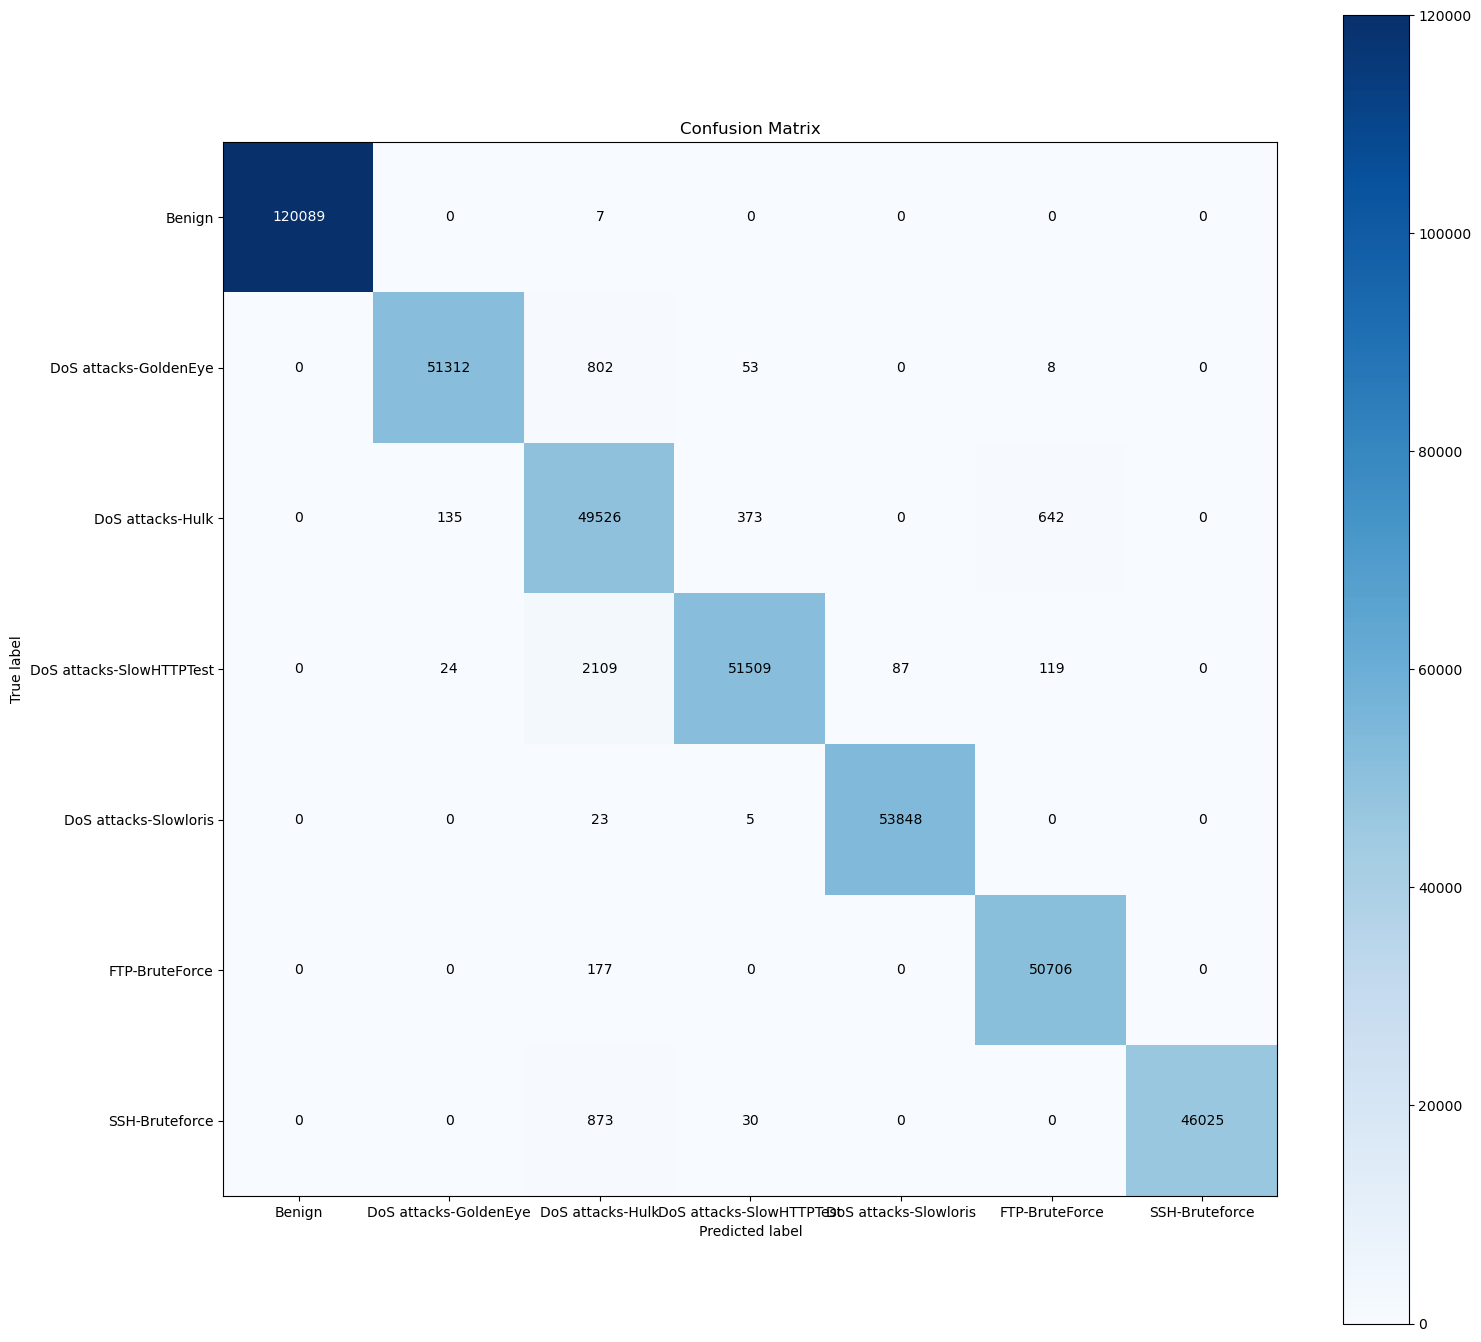

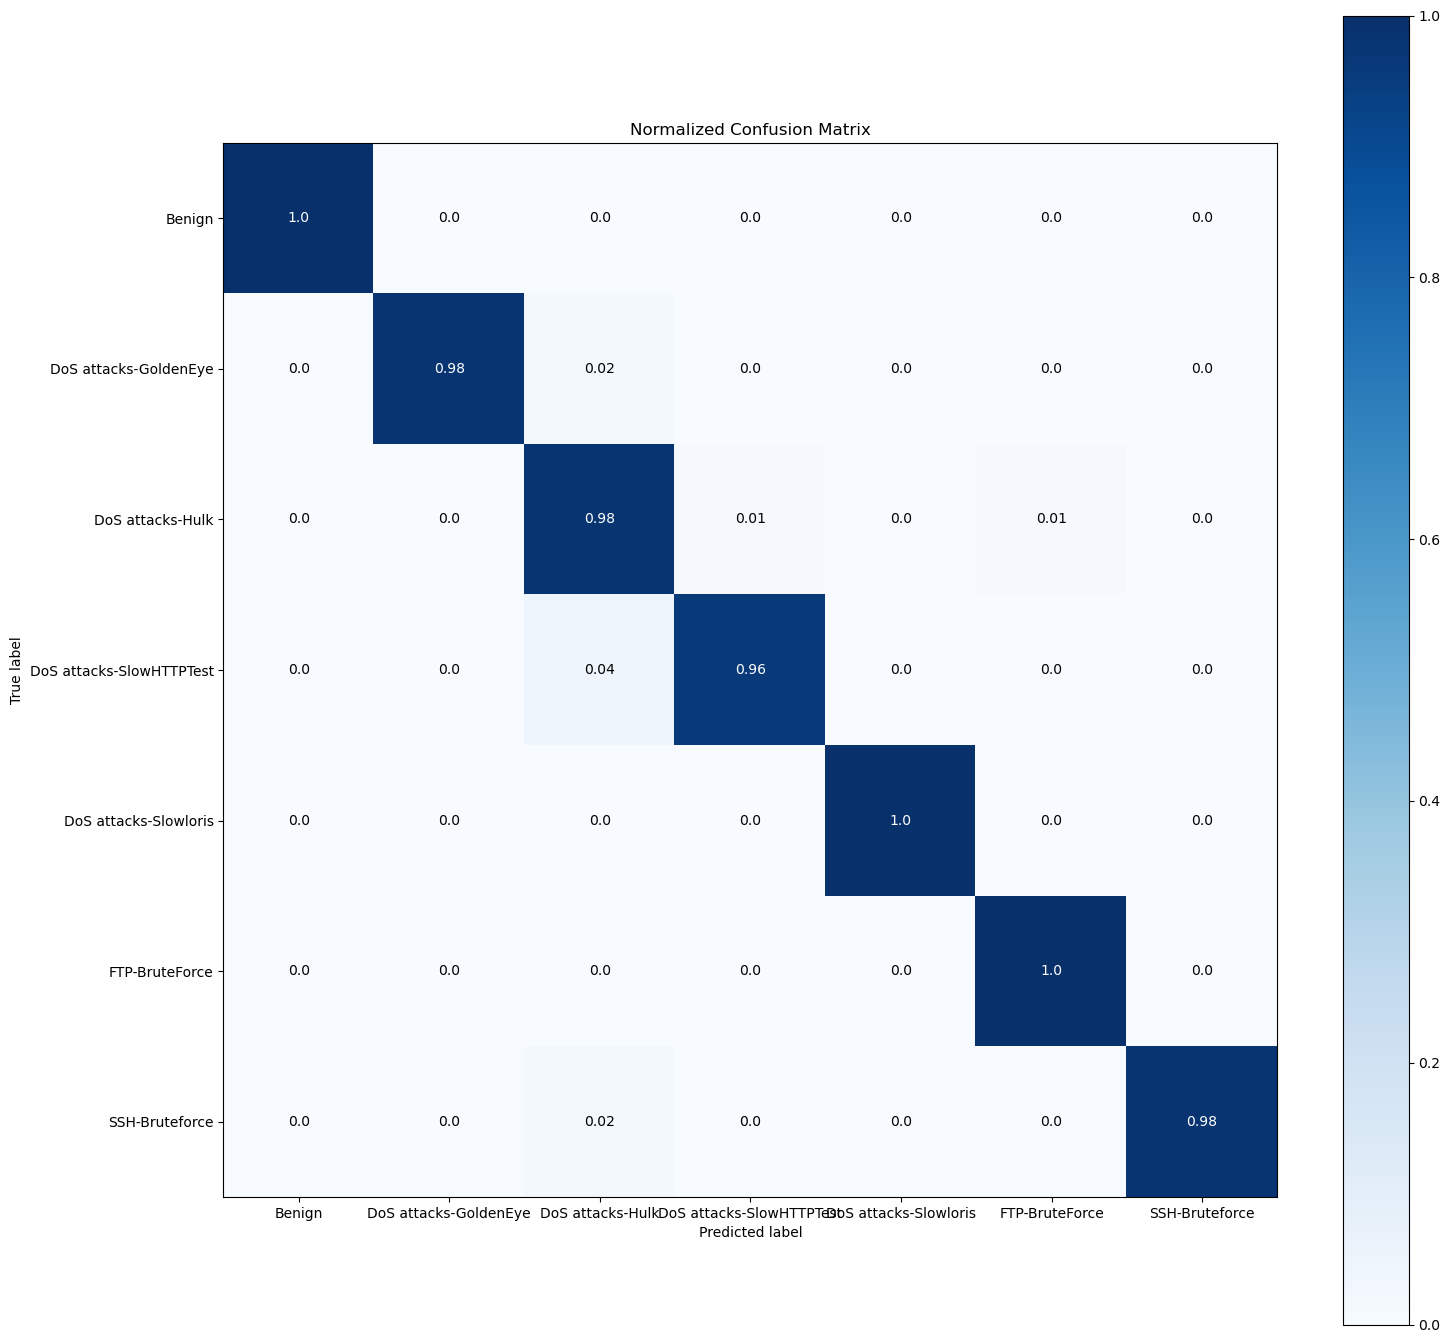

In [47]:
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1,figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True,figsize= (17,17))

 ### Random Forest Test evaluation

In [48]:
X_testArr = X_test.to_numpy()
Y_pred=clf.predict(X_testArr)
LabelsArr = np.array(Labels1)

y_testree1 = []
for i in range(0, Y_test.size):
    for j in range(0, LabelsArr.size):
        if Y_test[i] == j:
            y_testree1.append(Labels[j])

y_predtree1 = []
for i in range(0, Y_pred.size):
    for j in range(0, LabelsArr.size):
        if Y_pred[i] == j:
            y_predtree1.append(Labels[j])

In [49]:
print(classification_report(y_testree1, y_predtree1, digits=8, zero_division= "warn"))


                          precision    recall  f1-score   support

                  Benign  0.98837102 0.99950354 0.99390611     32228
   DoS attacks-GoldenEye  0.98752359 0.94001996 0.96318642     10020
        DoS attacks-Hulk  0.94915418 0.95748415 0.95330097     10255
DoS attacks-SlowHTTPTest  0.97475271 0.93132313 0.95254315     11110
   DoS attacks-Slowloris  0.95268762 0.99882967 0.97521315     11108
          FTP-BruteForce  0.99986784 0.99953759 0.99970269     15138
          SSH-Bruteforce  0.99916297 0.99841084 0.99878676     11956

                accuracy                      0.98178068    101815
               macro avg  0.97878856 0.97501555 0.97666275    101815
            weighted avg  0.98193520 0.98178068 0.98167511    101815



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

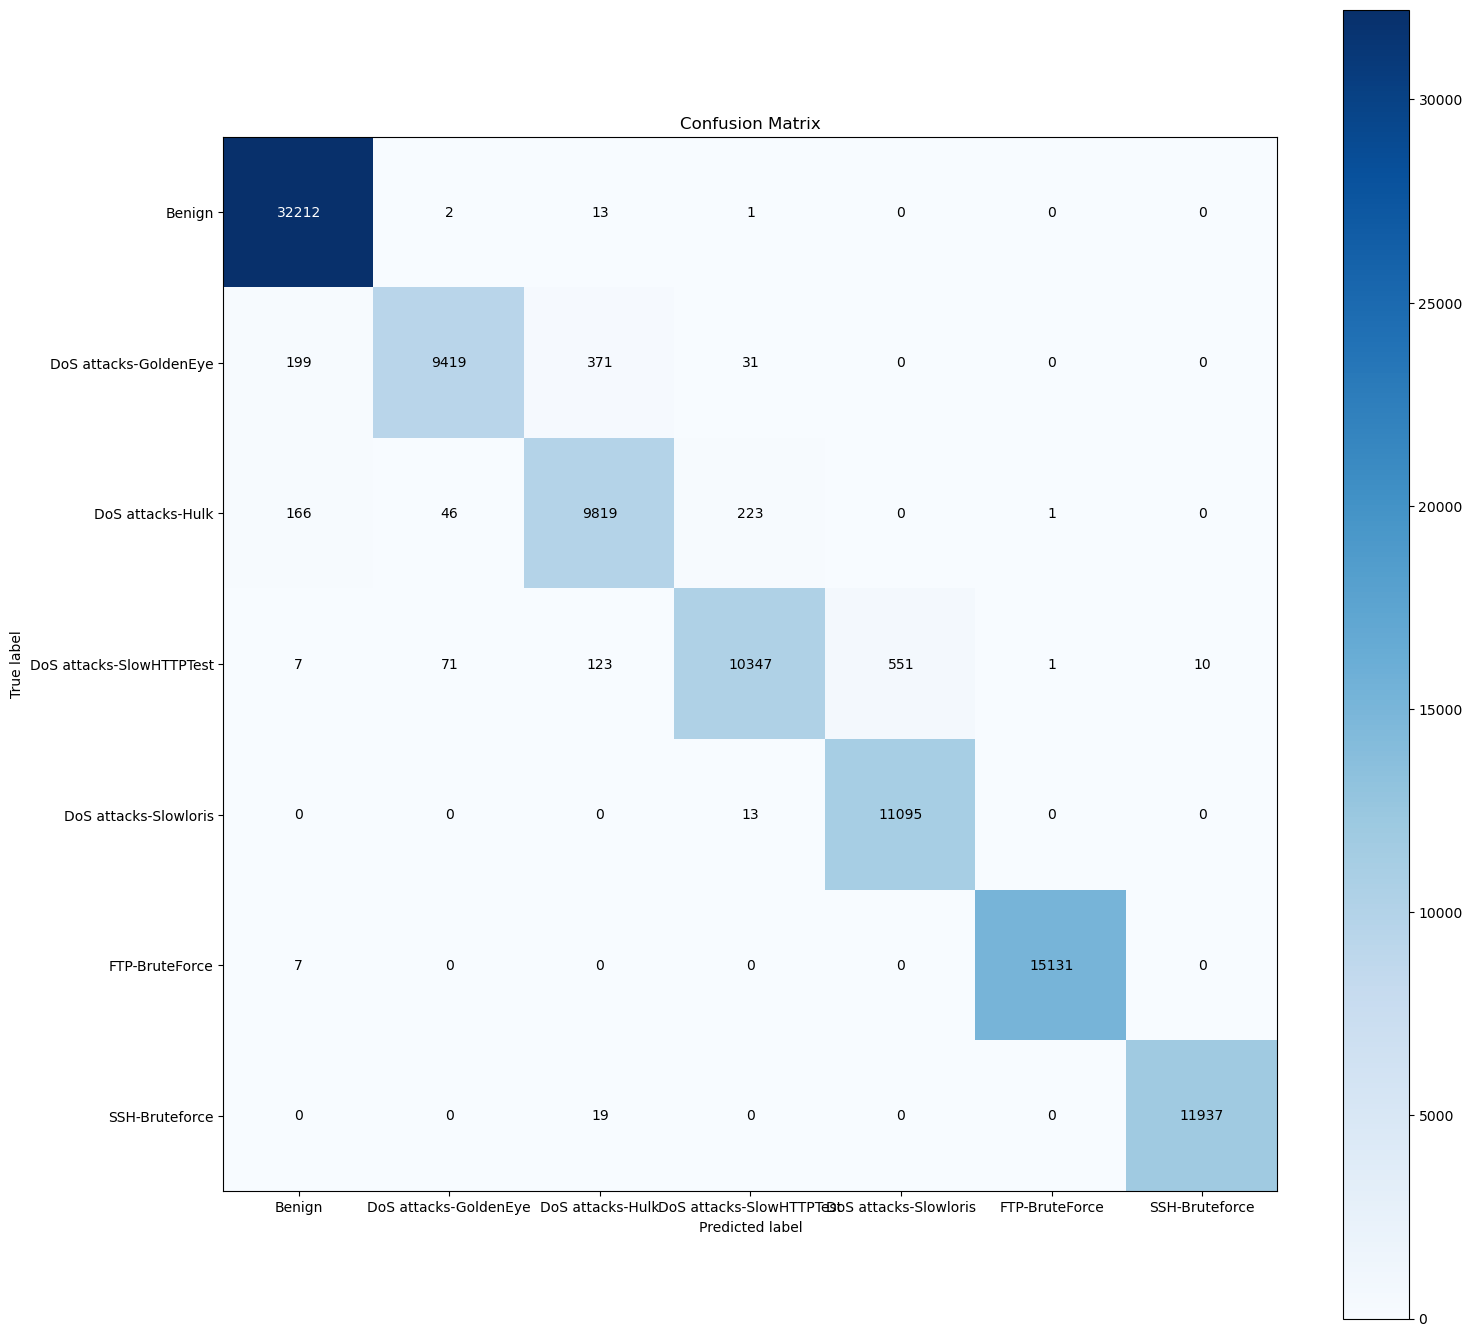

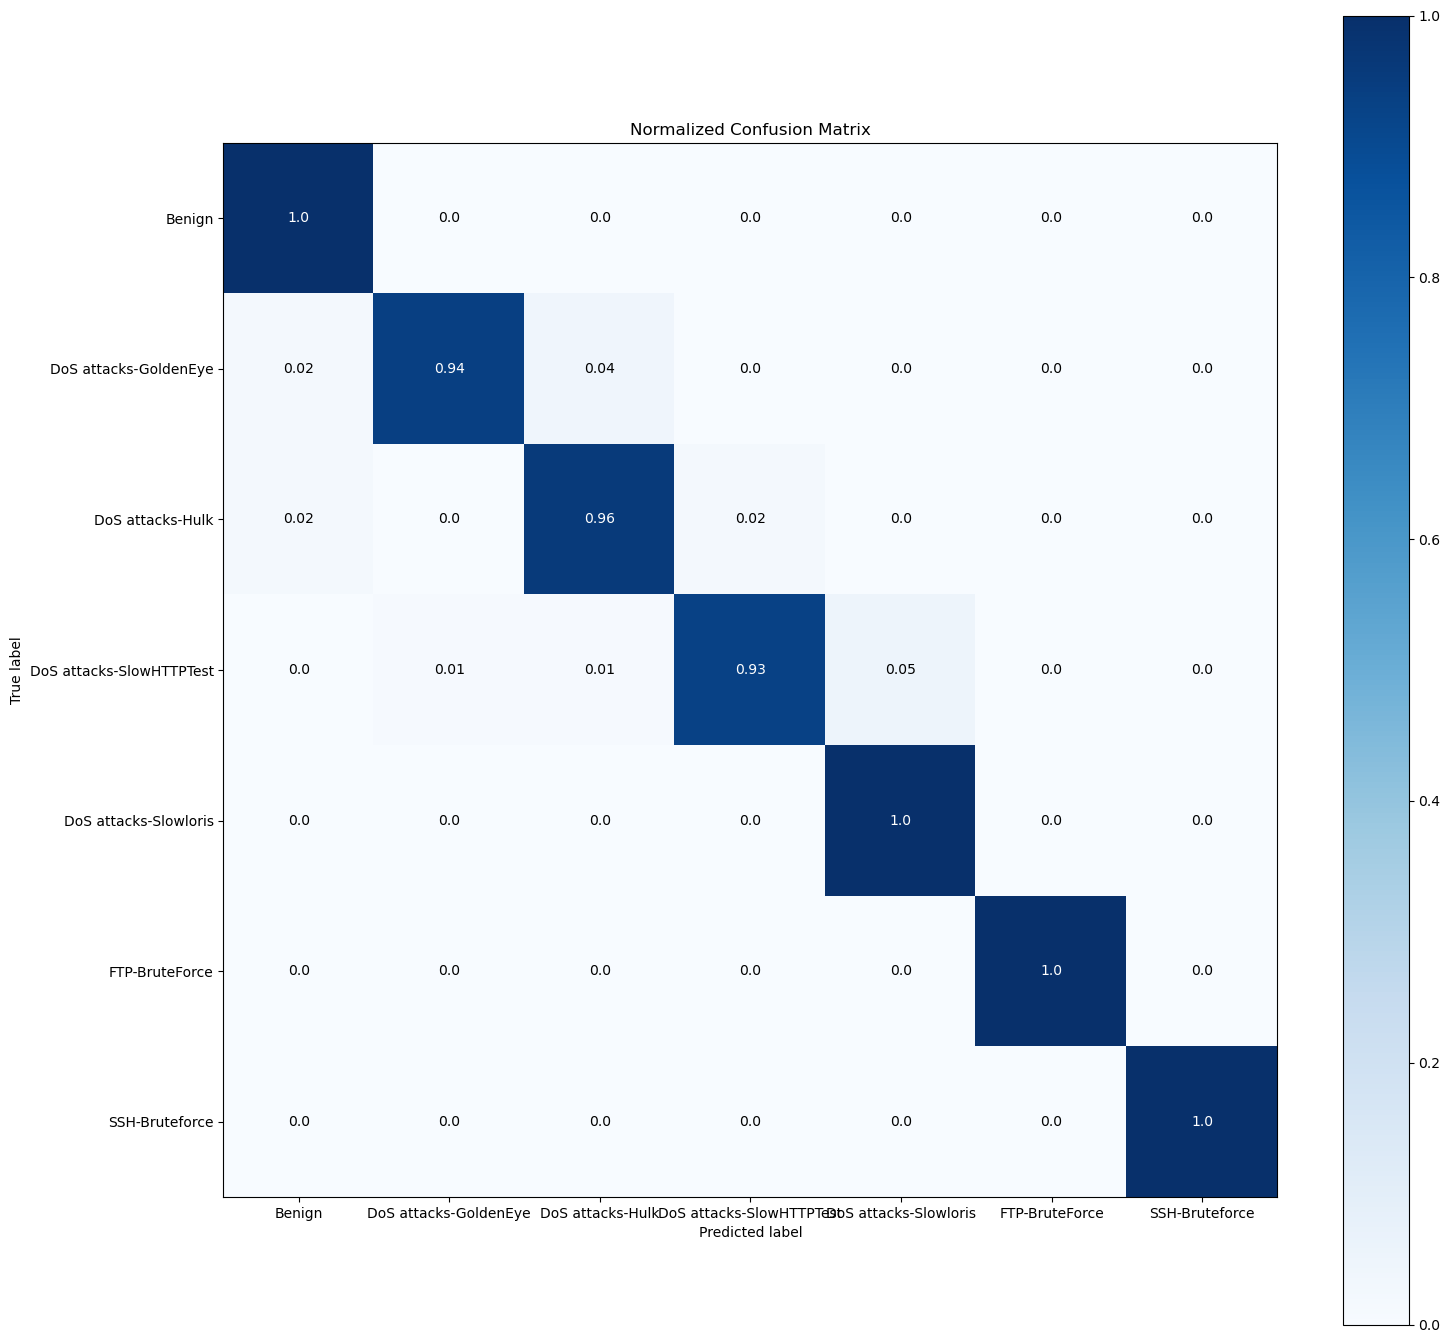

In [50]:
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1,figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True,figsize= (17,17))

## Decision Tree

In [51]:
from matplotlib.backends.backend_pdf import PdfPages
accuracy_ant=0
accuracy_med=0
accuracy_pon=0
accuracy_pon_ant=0
best=0
dist_ant=1000
inicio = time.time()
from tqdm import tqdm
#Evaluate every Random Forest' decision tree and choose the fittest.
for i in range(n_estimators):
    aux_clf = clf.estimators_[i]
    y_pred_train=aux_clf.predict(X_trainArr)
    y_pred_test=aux_clf.predict(X_testArr)
    accuracy=accuracy_score(Y_test, y_pred_test)
    
    accuracy_train=accuracy_score(Y_train, y_pred_train)
    accuracy_pon = accuracy_train*accuracy
    
    if accuracy_pon > accuracy_pon_ant:
        pon=i
        accuracy_pon_ant=accuracy_pon
        accuracy_pon_train = accuracy_train
        accuracy_pon_test = accuracy
        arbol_tree=clf.estimators_[pon]
        
import time


fin = time.time()

print(fin-inicio)




36.411781787872314


In [53]:
import graphviz
# DOT data
#dot_data = tree.export_graphviz(arbol_tree, out_file=None, feature_names=features,  
                               # class_names=Labels,
                               # filled=True)
#graph = graphviz.Source(dot_data, format="png") 
#graph
#graph.render("decision_tree_graphivz7")

In [55]:
#fig3 = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(clf.estimators_[pon], feature_names=features,  class_names=Labels,filled=True)

#fig3.suptitle('Arbol numero: '+str(pon)+' Precision test: '+ str(round(accuracy_pon_test,3)) +' Precision entrenamiento: '+ str(round(accuracy_pon_train,3)))


### Evaluation of the Decision Tree

In [56]:

Y_pred_train=arbol_tree.predict(X_trainArr)
Y_pred_test=arbol_tree.predict(X_testArr)
accuracy_train=accuracy_score(Y_train, y_pred_train)
accuracy_test=accuracy_score(Y_test, y_pred_test)
print("precision train: ",accuracy_train,"precision test: ",accuracy_test)

precision train:  0.9848184987934149 precision test:  0.9703187153169965


In [57]:

Y_pred=arbol_tree.predict(X_testArr)
LabelsArr = np.array(Labels1)

y_testree1 = []
for i in range(0, Y_test.size):
    for j in range(0, LabelsArr.size):
        if Y_test[i] == j:
            y_testree1.append(Labels[j])

y_predtree1 = []
for i in range(0, Y_pred.size):
    for j in range(0, LabelsArr.size):
        if Y_pred[i] == j:
            y_predtree1.append(Labels[j])

In [58]:

print(classification_report(y_testree1, y_predtree1, digits=8, zero_division= "warn"))

                          precision    recall  f1-score   support

                  Benign  0.98903488 0.98796078 0.98849754     32228
   DoS attacks-GoldenEye  0.95255219 0.95169661 0.95212421     10020
        DoS attacks-Hulk  0.94840962 0.95368113 0.95103807     10255
DoS attacks-SlowHTTPTest  0.96600108 0.96669667 0.96634875     11110
   DoS attacks-Slowloris  0.98780047 0.98406554 0.98592947     11108
          FTP-BruteForce  0.99900970 0.99960365 0.99930659     15138
          SSH-Bruteforce  0.99715909 0.99815992 0.99765925     11956

                accuracy                      0.98112262    101815
               macro avg  0.97713815 0.97740918 0.97727198    101815
            weighted avg  0.98114160 0.98112262 0.98113083    101815



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

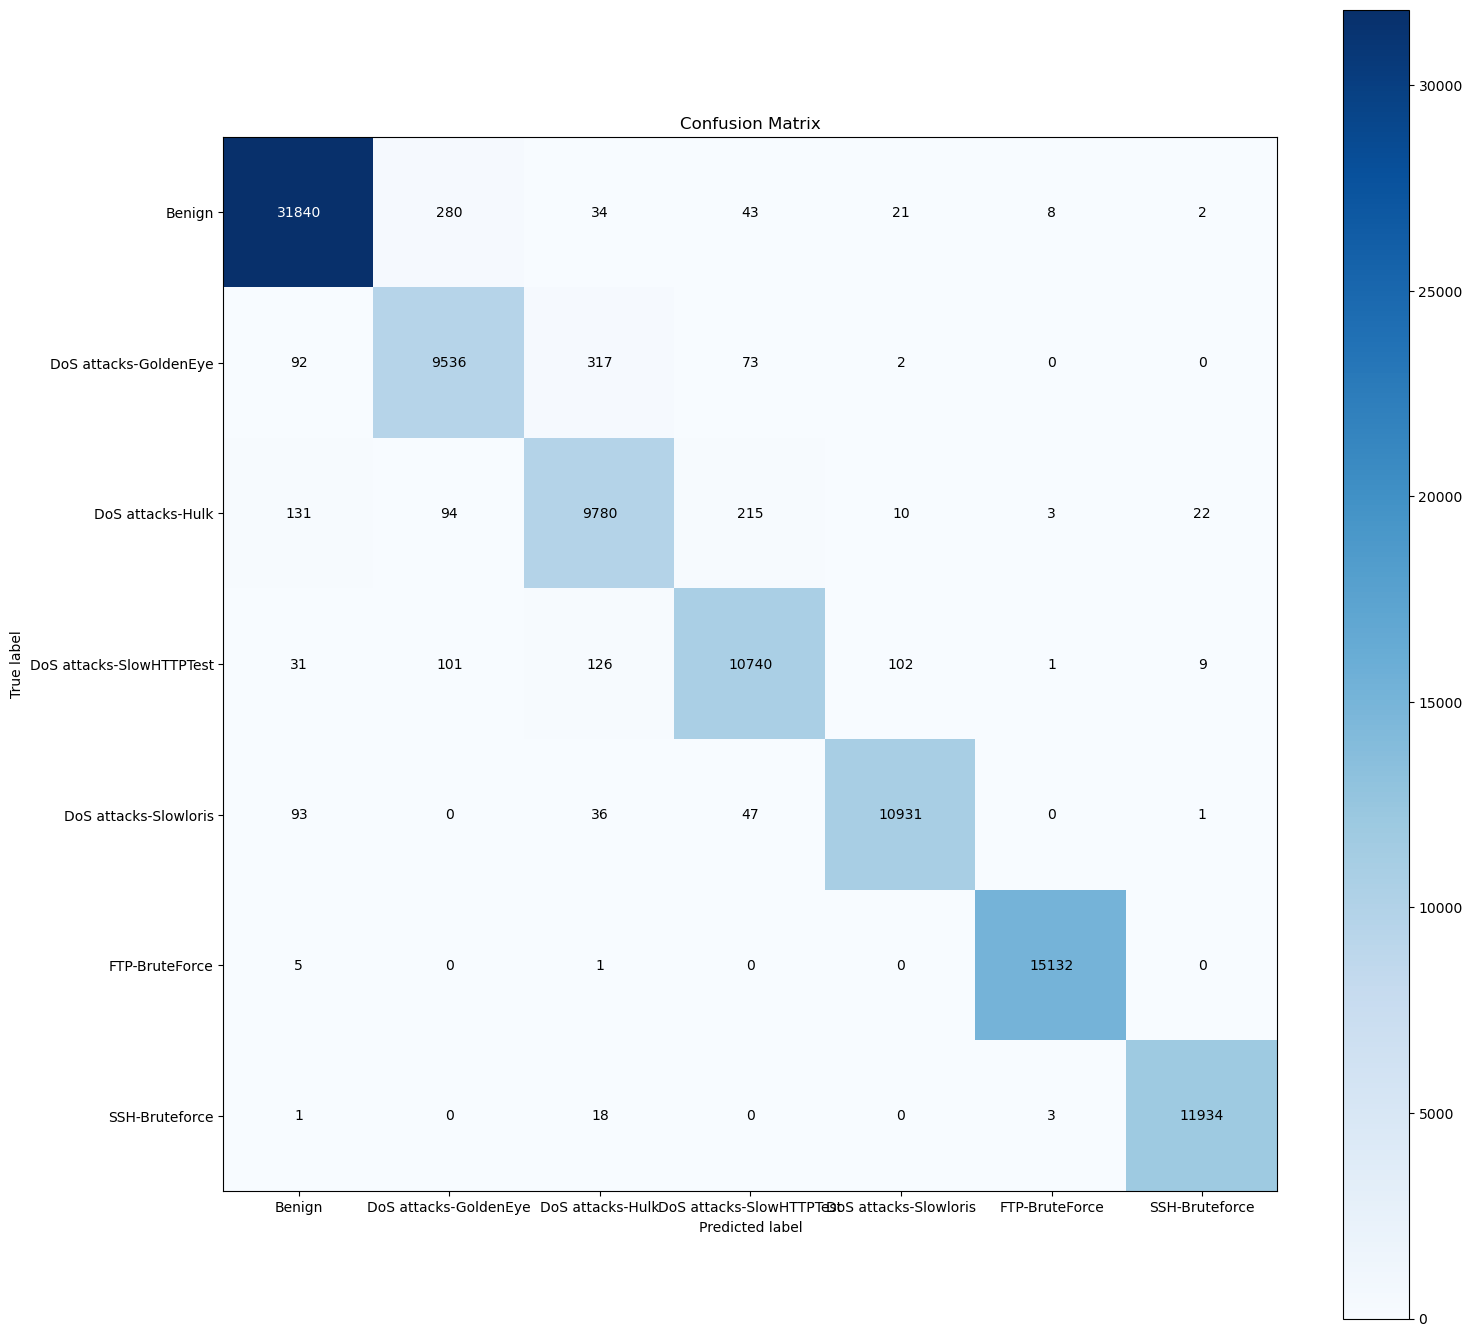

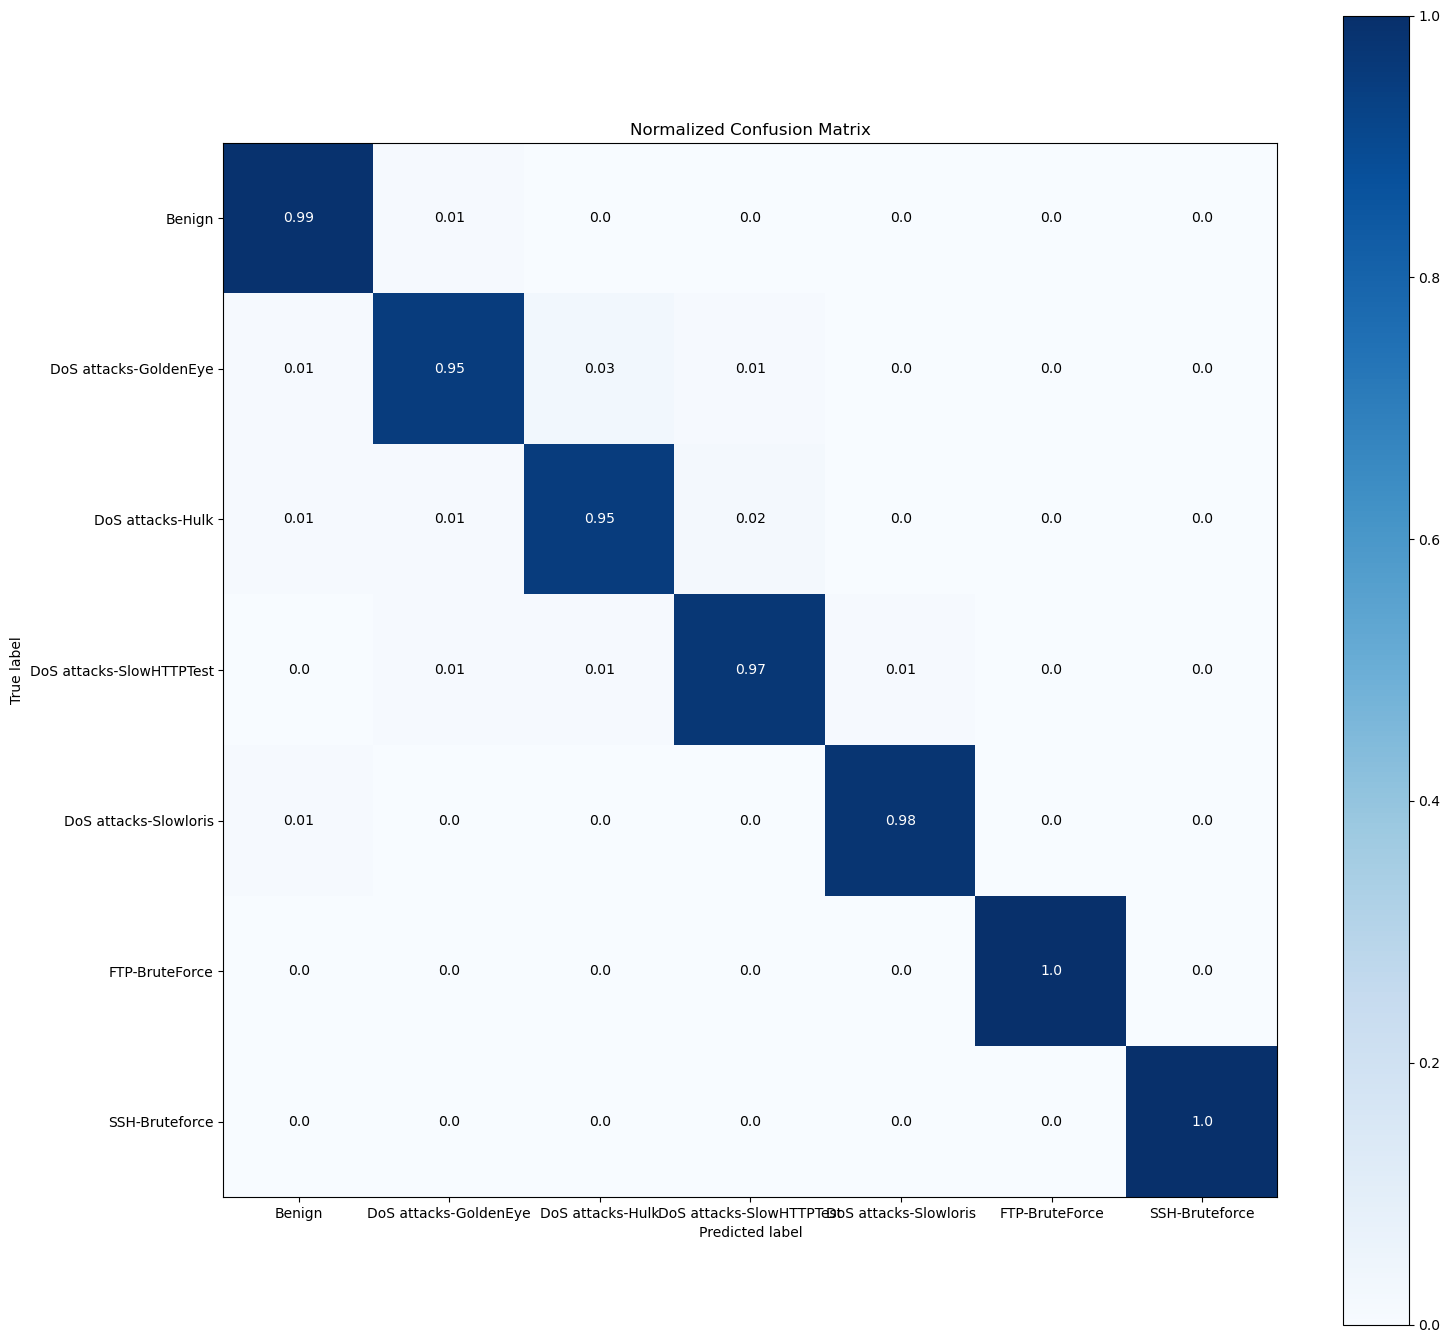

In [59]:
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1,figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True,figsize= (17,17))


## Get Decision Tree times

In [60]:
dataset0 = pd.read_csv('Train.csv', encoding = "ISO-8859-1") # lectura de datos
dataset01 = pd.read_csv('Test.csv', encoding = "ISO-8859-1") # lectura de datos

dataset0.replace([np.inf, -np.inf], -1, inplace=True) 
dataset0.replace([np.nan, -np.nan], -1, inplace=True)

dataset01.replace([np.inf, -np.inf], -1, inplace=True) 
dataset01.replace([np.nan, -np.nan], -1, inplace=True)

dataset0 = dataset0.drop(dataset0[dataset0['Dst Port']=='Dst Port'].index)
dataset01 = dataset01.drop(dataset01[dataset01['Dst Port']=='Dst Port'].index)

#Eliminamos las columnas innecesarias

dataset0 = dataset0.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                       'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
dataset01 = dataset01.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                          'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
#Quitamos direcciones IP dest y src para no introducir sesgos, lo mismo con los puertos
#Quitar el puerto de destino es una modificación con respecto al trabajo original
#Eliminamos la columna de timestamp para no tener sesgo
dataset01 = dataset01.drop(['Timestamp'], axis=1)
dataset0 = dataset0.drop(['Timestamp'], axis=1)


X_train0=dataset0.iloc[:, 0:72] #Luego obtenemos las características del flujo
X_test0=dataset01.iloc[:, 0:72]



for col in X_train0.columns:
    if X_train0[col].var() == 0:
        print(col)
        X_train0=X_train0.drop(col, axis =1)
        X_test0=X_test0.drop(col, axis =1)
        
X_trainArr0=X_train0.to_numpy()
X_testArr0=X_test0.to_numpy()

X_tiempo=np.concatenate((X_trainArr0, X_testArr0), axis=0)

print(X_tiempo.shape)

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
URG Flag Cnt
CWE Flag Count
ECE Flag Cnt
Fwd Byts/b Avg
Fwd Pkts/b Avg
Fwd Blk Rate Avg
Bwd Byts/b Avg
Subflow Bwd Pkts
Active Mean
Active Std
Active Max
Active Min
(532148, 57)


In [61]:
import time
inicio = time.time()
Y_predtree=clf.predict(X_tiempo)
fin = time.time()

print(fin-inicio)
print(532148/(fin-inicio))

14.683082342147827
36242.25401722823
